Sample Tremor Signals:
      Time  Rest Tremor  Postural Tremor  Intention Tremor  No Tremor
0  0.00000    -0.009766        -0.005689          0.006132   0.001950
1  0.01001     0.020036         0.028388          0.071280   0.016419
2  0.02002     0.046851         0.075101          0.039341   0.029814
3  0.03003     0.090164         0.120027          0.081633   0.006782
4  0.04004     0.101992         0.141065          0.110949   0.038310


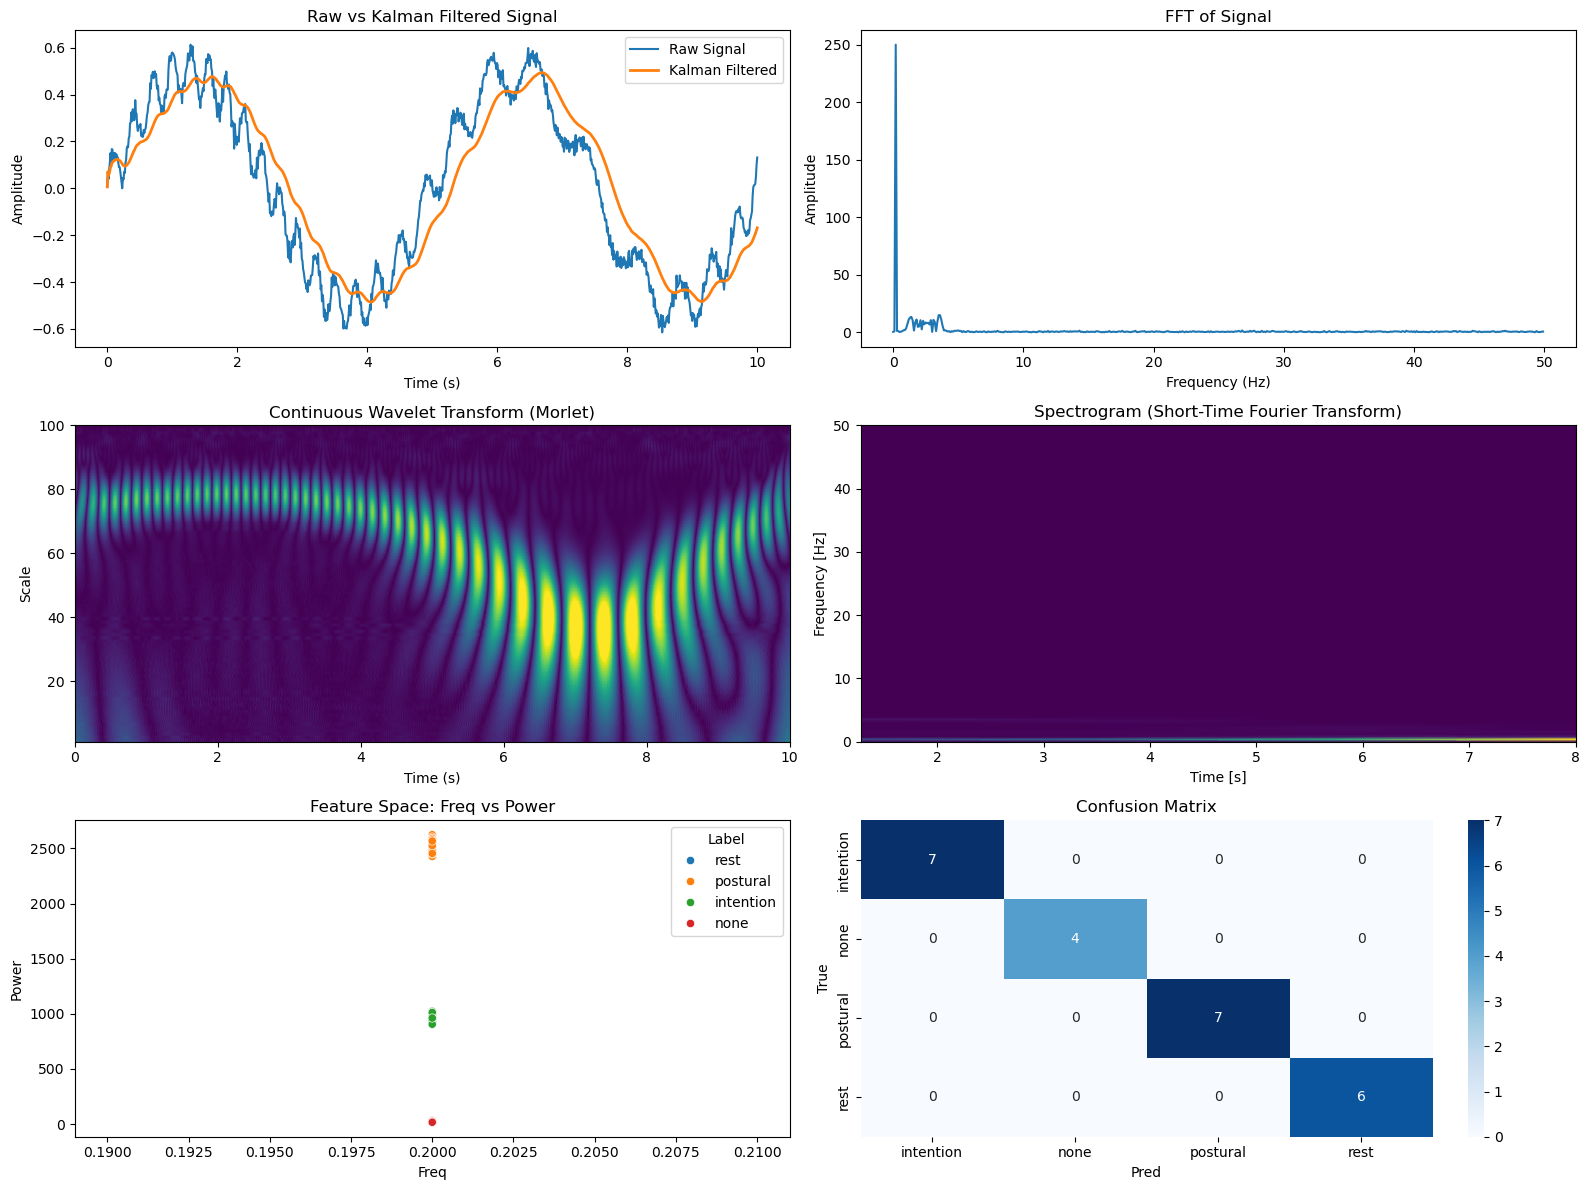

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
from scipy.fft import fft, fftfreq
import pywt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Kalman Filter ---
def simple_kalman_filter(z, Q=1e-5, R=1e-2):
    n = len(z)
    x_hat = np.zeros(n)
    P = 1.0
    x_hat[0] = z[0]
    for t in range(1, n):
        x_hat_minus = x_hat[t-1]
        P_minus = P + Q
        K = P_minus / (P_minus + R)
        x_hat[t] = x_hat_minus + K * (z[t] - x_hat_minus)
        P = (1 - K) * P_minus
    return x_hat

# --- Simulate Signals ---
fs = 100
t = np.linspace(0, 10, fs * 10)
labels = ["rest", "postural", "intention", "none"]

def simulate_tremor(t, tremor_type):
    base = 0.5 * np.sin(2 * np.pi * 0.2 * t)
    tremor = {
        "rest": 0.1 * np.sin(2 * np.pi * 4 * t),
        "postural": 0.1 * np.sin(2 * np.pi * 6 * t),
        "intention": 0.1 * np.sin(2 * np.pi * (3 + 0.5 * np.sin(0.5 * t)) * t),
        "none": 0.0
    }.get(tremor_type, 0.0)
    noise = 0.02 * np.random.randn(len(t))
    return base + tremor + noise

data, features, classes = [], [], []

for label in labels:
    for _ in range(30):
        signal_data = simulate_tremor(t, label)
        fft_vals = np.abs(fft(signal_data))
        freqs = fftfreq(len(t), 1/fs)
        dominant_freq = freqs[np.argmax(fft_vals[:len(freqs)//2])]
        tremor_power = np.sum(fft_vals[(freqs > 3) & (freqs < 8)]**2)
        coef, _ = pywt.cwt(signal_data, scales=np.arange(1, 100), wavelet='morl')
        cwt_power = np.mean(np.abs(coef))
        filtered_signal = simple_kalman_filter(signal_data)
        kalman_var = np.var(filtered_signal)
        features.append([dominant_freq, tremor_power, cwt_power, kalman_var])
        classes.append(label)
        data.append(signal_data)

# --- Classification ---
X = np.array(features)
y = np.array(classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# --- Sample DataFrame for Visualization ---
sample_signals = {
    'Time': t,
    'Rest Tremor': data[0],
    'Postural Tremor': data[30],
    'Intention Tremor': data[60],
    'No Tremor': data[90]
}
sample_df = pd.DataFrame(sample_signals)
print("Sample Tremor Signals:")
print(sample_df.head())

# --- Visualization ---
sample_signal = data[60]  # Intention tremor
filtered_signal = simple_kalman_filter(sample_signal)
fft_vals = np.abs(fft(sample_signal))
freqs = fftfreq(len(t), 1/fs)
coef, freqs_cwt = pywt.cwt(sample_signal, scales=np.arange(1, 100), wavelet='morl')
f, t_spec, Sxx = signal.spectrogram(sample_signal, fs)

plt.figure(figsize=(16, 12))

# Raw vs EKF-filtered
plt.subplot(3, 2, 1)
plt.plot(t, sample_signal, label='Raw Signal')
plt.plot(t, filtered_signal, label='Kalman Filtered', linewidth=2)
plt.title("Raw vs Kalman Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# FFT
plt.subplot(3, 2, 2)
plt.plot(freqs[:len(freqs)//2], fft_vals[:len(freqs)//2])
plt.title("FFT of Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

# Wavelet Transform
plt.subplot(3, 2, 3)
plt.imshow(np.abs(coef), extent=[0, 10, 1, 100], cmap='viridis', aspect='auto',
           vmax=np.percentile(np.abs(coef), 99))
plt.title("Continuous Wavelet Transform (Morlet)")
plt.ylabel("Scale")
plt.xlabel("Time (s)")

# Spectrogram
plt.subplot(3, 2, 4)
plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram (Short-Time Fourier Transform)')

# Classification Feature Space (2D projection)
X_df = pd.DataFrame(X, columns=["Freq", "Power", "CWT", "Var"])
X_df["Label"] = y
sns.scatterplot(data=X_df, x="Freq", y="Power", hue="Label", ax=plt.subplot(3, 2, 5))
plt.title("Feature Space: Freq vs Power")

# Confusion Matrix
plt.subplot(3, 2, 6)
predicted_df = pd.DataFrame({"True": y_test, "Pred": y_pred})
sns.heatmap(pd.crosstab(predicted_df["True"], predicted_df["Pred"]), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()


In [10]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [11]:
import h5py
import pandas as pd

path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/3Hz_trial2/IMU.h5'

with h5py.File(path, 'r') as file:
    print("Top-level keys:", list(file.keys()))
    a_group_key = list(file.keys())[0]

    group = file[a_group_key]
    print(f"Contents of group '{a_group_key}':", list(group.keys()))

    dataset_group_key = 'DOT_40195BFD802900B5'
    if dataset_group_key in group:
        subgroup = group[dataset_group_key]
        print(f"Contents of subgroup '{dataset_group_key}':", list(subgroup.keys()))

        # Now, find the actual dataset inside
        for name in subgroup.keys():
            item = subgroup[name]
            if isinstance(item, h5py.Dataset):
                print(f"Found dataset: {name}")
                data = item[:]
                print("Shape:", data.shape)
                print("Dtype:", data.dtype)

                # Optionally convert to DataFrame
                if data.dtype.names:
                    df = pd.DataFrame(data)
                    print(df.head())
                else:
                    print(data[:5])


Top-level keys: ['IMU']
Contents of group 'IMU': ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Contents of subgroup 'DOT_40195BFD802900B5': ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']
Found dataset: Accelerometer
Shape: (3, 848)
Dtype: float64
[[  5.63160133   4.76674175   4.80432892 ...   5.11081553   4.7338171
    4.10395336]
 [ -8.85337925 -10.69367027 -11.06832409 ... -10.77161598  -8.86718559
   -7.28015518]
 [  0.58448315  -0.84297699  -0.66061592 ...   1.48369575   2.4476192
    1.4559536 ]]
Found dataset: Gyroscope
Shape: (3, 848)
Dtype: float64
[[-153.46228027 -112.3190918   -53.62031555 ...  165.54255676
   190.31756592  176.57295227]
 [  34.74007416   12.8619194     1.32615745 ...   17.82766533
     8.1696043    -4.23853731]
 [  29.94682884   27.17697525   20.37045288 ...  -15.54736328
   -

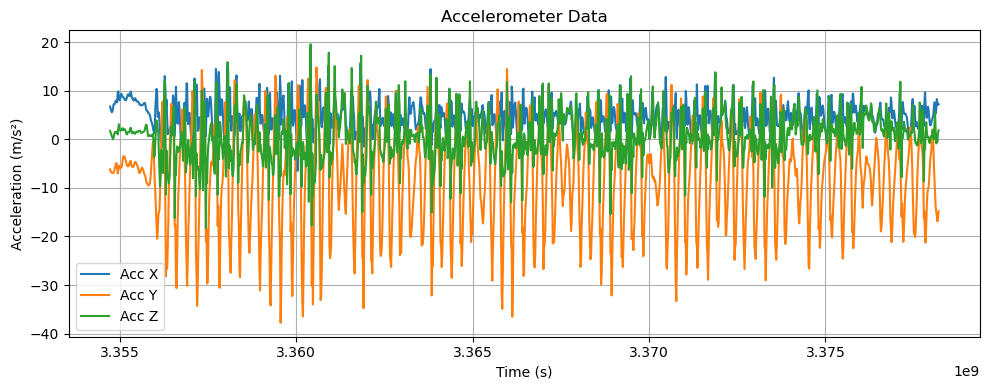

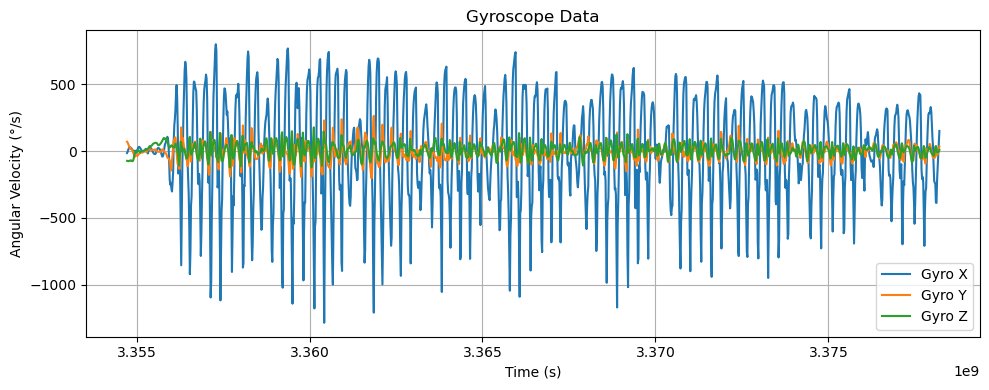

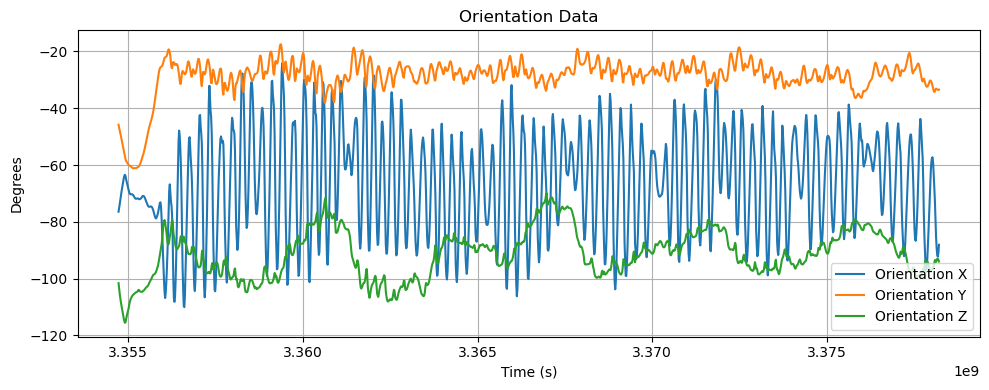

In [12]:
import h5py
import matplotlib.pyplot as plt

files = []

path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial2/IMU.h5'

with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    
    # Load datasets
    acc = imu['Accelerometer'][:]  # shape (3, 632)
    gyro = imu['Gyroscope'][:]
    orient = imu['Orientation'][:]
    time = imu['Timestamp_Sensor'][:]  # shape (632,)
    
    # Plot Accelerometer
    plt.figure(figsize=(10, 4))
    plt.plot(time, acc[0], label='Acc X')
    plt.plot(time, acc[1], label='Acc Y')
    plt.plot(time, acc[2], label='Acc Z')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Accelerometer Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Gyroscope
    plt.figure(figsize=(10, 4))
    plt.plot(time, gyro[0], label='Gyro X')
    plt.plot(time, gyro[1], label='Gyro Y')
    plt.plot(time, gyro[2], label='Gyro Z')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (°/s)')
    plt.title('Gyroscope Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Orientation plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, orient[0], label='Orientation X')
    plt.plot(time, orient[1], label='Orientation Y')
    plt.plot(time, orient[2], label='Orientation Z')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Orientation Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


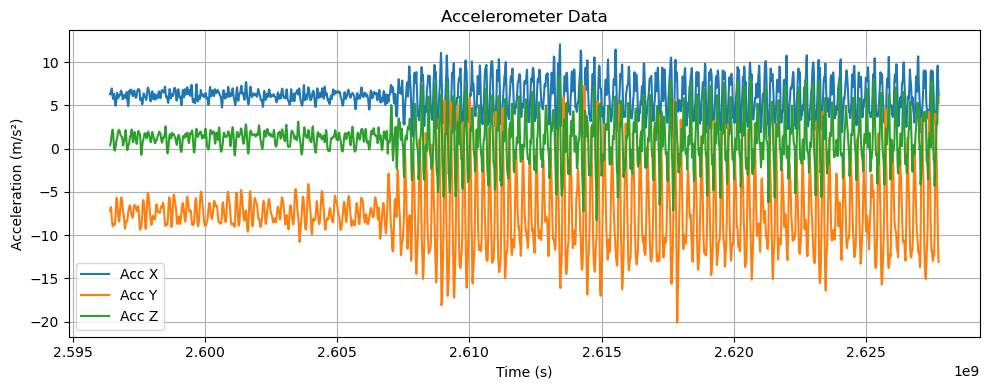

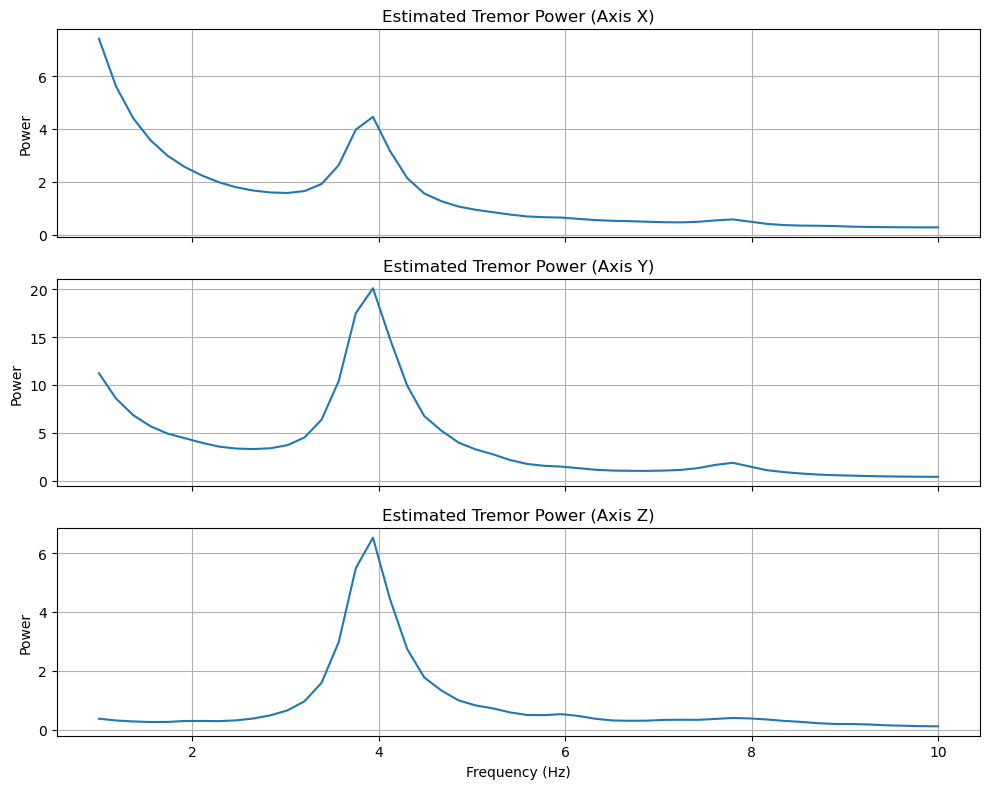

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def kalman_filter_bank(accel_data, fs, freq_range=(1, 10), num_freqs=50, q=1e-4, r=1e-1):
    def kalman_sine_filter(y, f, fs, q, r):
        n = len(y)
        dt = 1 / fs
        omega = 2 * np.pi * f

        x = np.zeros((2, n))
        P = np.eye(2)
        Q = q * np.eye(2)
        R = r

        x_est = np.zeros((2, n))

        for k in range(n):
            H_k = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
            y_k = y[k]

            x_pred = x[:, k - 1] if k > 0 else np.zeros(2)
            P_pred = P + Q

            S = H_k @ P_pred @ H_k.T + R
            K = P_pred @ H_k.T / S
            residual = y_k - H_k @ x_pred
            x[:, k] = x_pred + (K * residual).flatten()
            P = (np.eye(2) - K @ H_k) @ P_pred

            x_est[:, k] = x[:, k]

        power = np.mean(np.sum(x_est ** 2, axis=0))
        return power

    freqs = np.linspace(freq_range[0], freq_range[1], num_freqs)
    power = np.zeros((3, num_freqs))

    for axis in range(3):
        for j, f in enumerate(freqs):
            power[axis, j] = kalman_sine_filter(accel_data[axis], f, fs, q, r)

    return freqs, power

# ==== Load IMU Data ====
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/2Hz_4Hz_trial1/IMU.h5'
with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    acc = imu['Accelerometer'][:]  # shape (3, N)
    gyro = imu['Gyroscope'][:]
    orient = imu['Orientation'][:]
    time = imu['Timestamp_Sensor'][:]  # shape (N,)

# ==== Plot raw accelerometer ====
plt.figure(figsize=(10, 4))
plt.plot(time, acc[0], label='Acc X')
plt.plot(time, acc[1], label='Acc Y')
plt.plot(time, acc[2], label='Acc Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Accelerometer Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Kalman Filter Bank Analysis ====
fs = 60  # adjust if needed
freqs, power = kalman_filter_bank(acc, fs)

# ==== Plot Estimated Power Spectrum ====
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axes = ['X', 'Y', 'Z']
for i in range(3):
    axs[i].plot(freqs, power[i])
    axs[i].set_title(f"Estimated Tremor Power (Axis {axes[i]})")
    axs[i].set_ylabel("Power")
    axs[i].grid(True)

axs[2].set_xlabel("Frequency (Hz)")
plt.tight_layout()
plt.show()


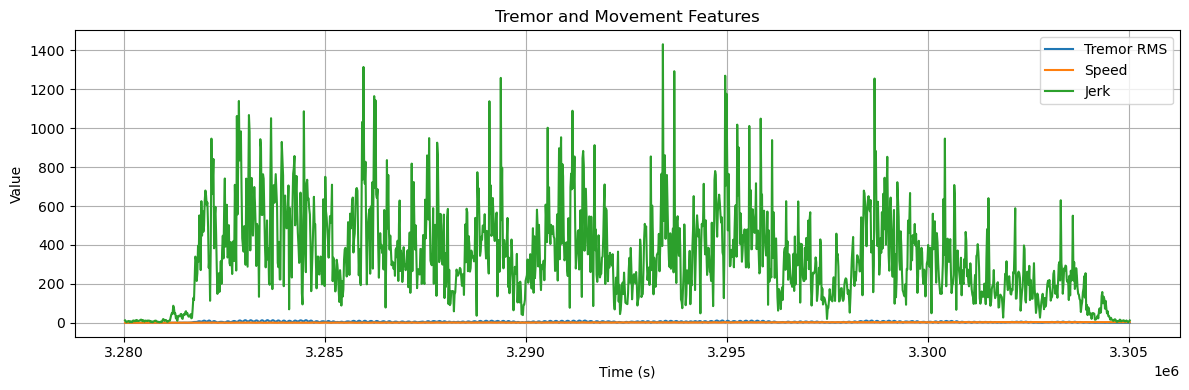

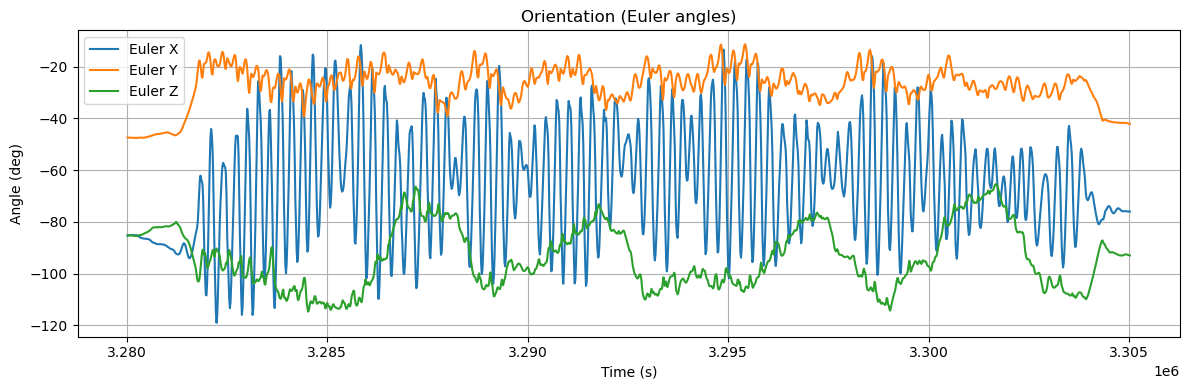

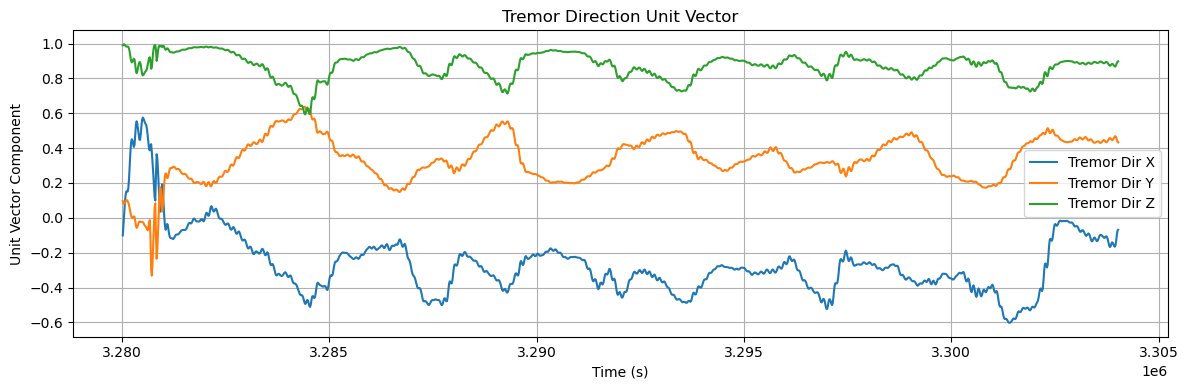

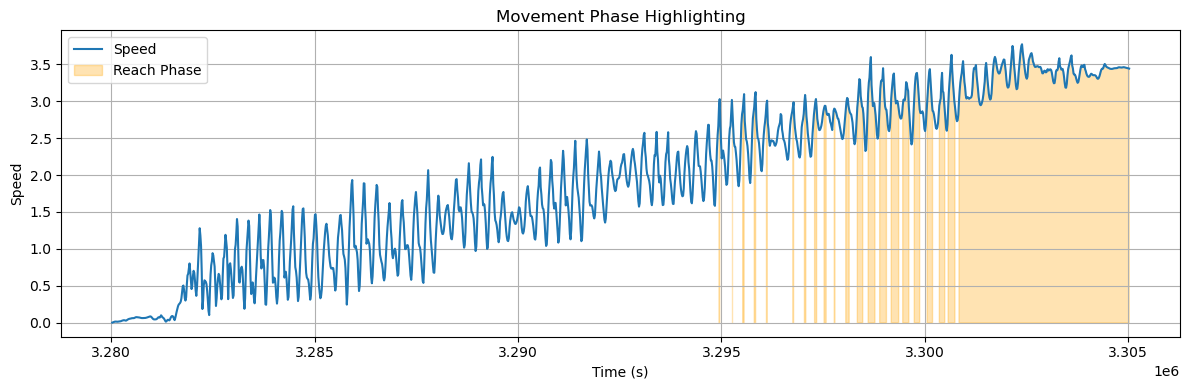

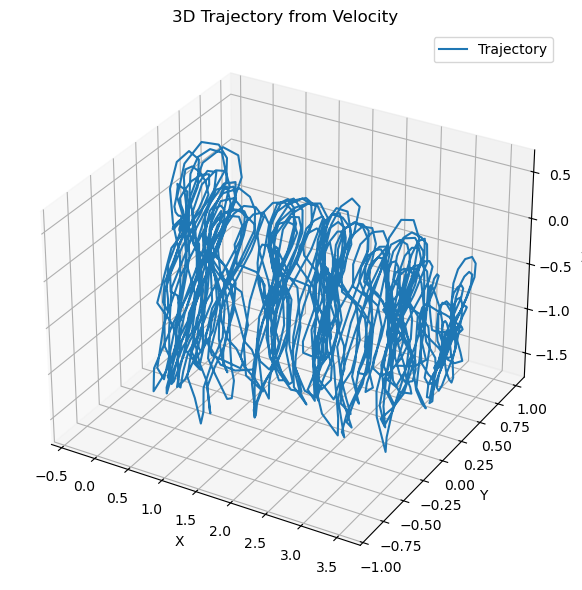

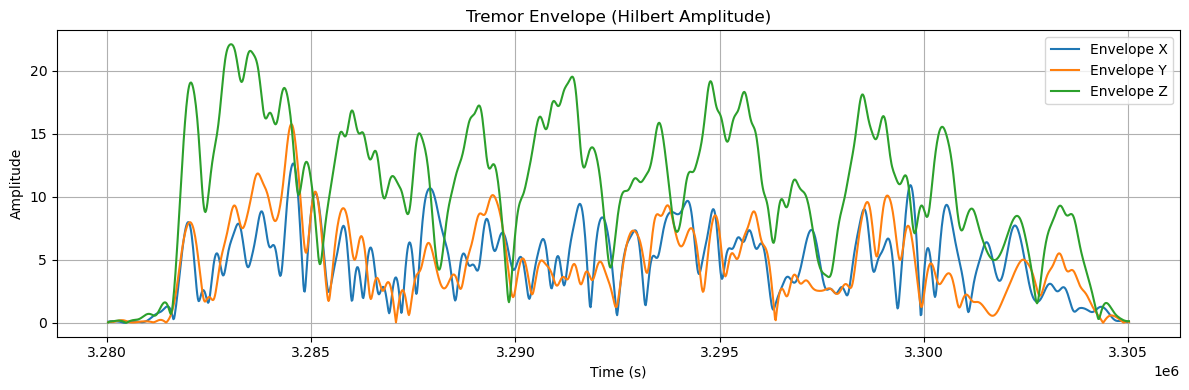

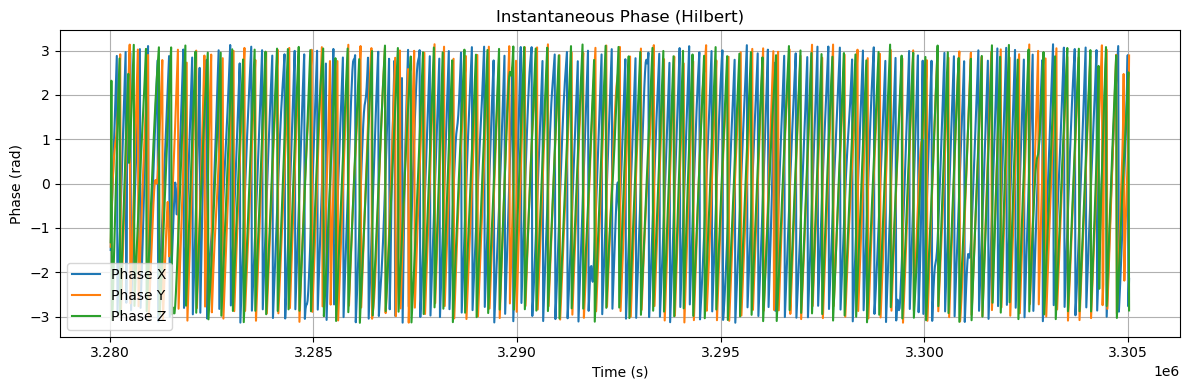

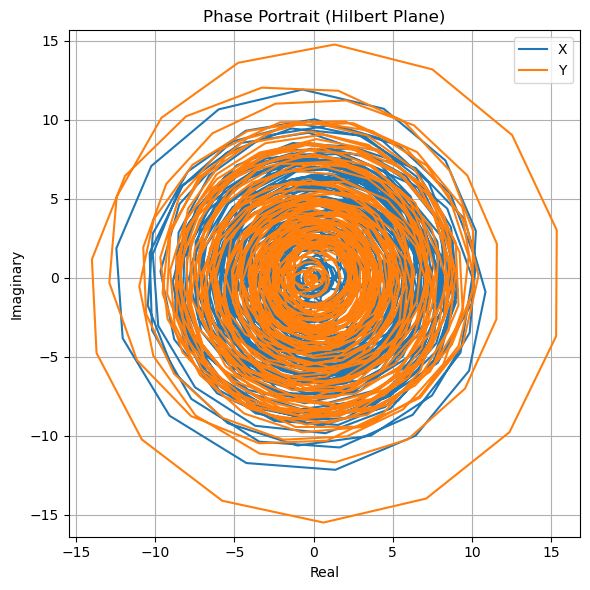

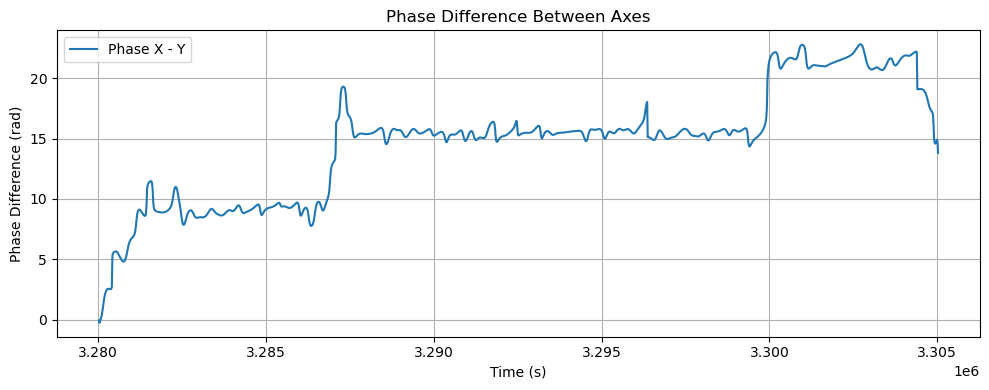

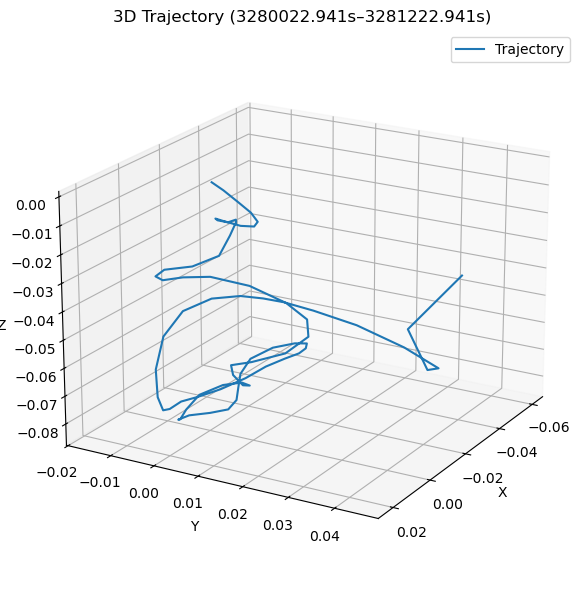

GIF saved as 'short_3d_trajectory.gif'


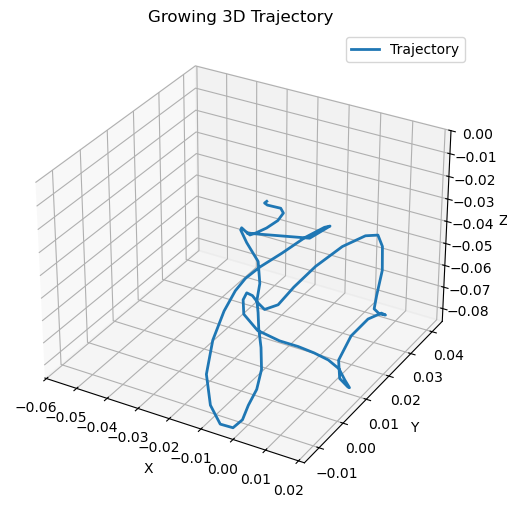

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from scipy.signal import butter, filtfilt, hilbert
from scipy.spatial.transform import Rotation as R
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# --- Load IMU data ---
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial1/IMU.h5'
with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    acc = imu['Accelerometer'][:]  # shape (3, N)
    gyro = imu['Gyroscope'][:]
    orient = imu['Orientation'][:]
    time = imu['Timestamp_Sensor'][:] / 1000.0  # Convert ms to seconds

# --- Sampling ---
fs = 60
dt = 1 / fs
N = acc.shape[1]

# --- Preprocess ---
acc = acc.T
gyro = gyro.T
orient = orient.T
rotations = R.from_euler('xyz', orient, degrees=True)
acc_world = rotations.apply(acc)
acc_world -= np.array([0, 0, 9.81])  # Remove gravity

# --- Band-pass filter for tremor ---
def bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

tremor_band = bandpass_filter(acc_world, 3, 6, fs)
tremor_rms = np.sqrt(np.mean(tremor_band**2, axis=1))

# --- Hilbert transform for phase ---
analytic_signal = hilbert(tremor_band, axis=0)
instantaneous_phase = np.angle(analytic_signal)
tremor_envelope = np.abs(analytic_signal)

# --- Tremor direction via PCA ---
pca = PCA(n_components=1)
window = int(fs * 1.0)
tremor_dir = [pca.fit(tremor_band[i:i+window]).components_[0] for i in range(N - window)]
tremor_dir = np.array(tremor_dir)

# --- Kinematics ---
velocity = np.cumsum(acc_world * dt, axis=0)
speed = np.linalg.norm(velocity, axis=1)
jerk = np.gradient(acc_world, axis=0) / dt
jerk_mag = np.linalg.norm(jerk, axis=1)

# --- Movement segmentation ---
movement_phase = np.zeros(N)
movement_phase[speed > np.percentile(speed, 75)] = 1

# --- Store results in DataFrame ---
df = pd.DataFrame({
    'time': time,
    'rms_tremor': tremor_rms,
    'speed': speed,
    'jerk': jerk_mag,
    'movement_phase': movement_phase,
    'euler_x': orient[:, 0],
    'euler_y': orient[:, 1],
    'euler_z': orient[:, 2],
    'tremor_dir_x': np.pad(tremor_dir[:, 0], (0, N - len(tremor_dir)), constant_values=np.nan),
    'tremor_dir_y': np.pad(tremor_dir[:, 1], (0, N - len(tremor_dir)), constant_values=np.nan),
    'tremor_dir_z': np.pad(tremor_dir[:, 2], (0, N - len(tremor_dir)), constant_values=np.nan)
})

# --- PLOTS ---

# 1. Tremor amplitude, speed, jerk
plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['rms_tremor'], label='Tremor RMS')
plt.plot(df['time'], df['speed'], label='Speed')
plt.plot(df['time'], df['jerk'], label='Jerk')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title('Tremor and Movement Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Orientation over time
plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['euler_x'], label='Euler X')
plt.plot(df['time'], df['euler_y'], label='Euler Y')
plt.plot(df['time'], df['euler_z'], label='Euler Z')
plt.title('Orientation (Euler angles)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Tremor direction (unit vector over time)
plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['tremor_dir_x'], label='Tremor Dir X')
plt.plot(df['time'], df['tremor_dir_y'], label='Tremor Dir Y')
plt.plot(df['time'], df['tremor_dir_z'], label='Tremor Dir Z')
plt.title('Tremor Direction Unit Vector')
plt.xlabel('Time (s)')
plt.ylabel('Unit Vector Component')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Movement phase highlighting
plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['speed'], label='Speed')
plt.fill_between(df['time'], 0, df['speed'], where=(df['movement_phase'] > 0), color='orange', alpha=0.3, label='Reach Phase')
plt.xlabel('Time (s)')
plt.ylabel('Speed')
plt.title('Movement Phase Highlighting')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. 3D Trajectory from integrated velocity
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(velocity[:, 0], velocity[:, 1], velocity[:, 2], label='Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory from Velocity')
ax.legend()
plt.tight_layout()
plt.show()

# 6. Tremor Envelope (Hilbert amplitude)
plt.figure(figsize=(12, 4))
plt.plot(time, tremor_envelope[:, 0], label='Envelope X')
plt.plot(time, tremor_envelope[:, 1], label='Envelope Y')
plt.plot(time, tremor_envelope[:, 2], label='Envelope Z')
plt.title('Tremor Envelope (Hilbert Amplitude)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Instantaneous Phase
plt.figure(figsize=(12, 4))
plt.plot(time, instantaneous_phase[:, 0], label='Phase X')
plt.plot(time, instantaneous_phase[:, 1], label='Phase Y')
plt.plot(time, instantaneous_phase[:, 2], label='Phase Z')
plt.title('Instantaneous Phase (Hilbert)')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Phase Portrait (Hilbert complex plane)
plt.figure(figsize=(6, 6))
plt.plot(analytic_signal[:, 0].real, analytic_signal[:, 0].imag, label='X')
plt.plot(analytic_signal[:, 1].real, analytic_signal[:, 1].imag, label='Y')
plt.title('Phase Portrait (Hilbert Plane)')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

# 9. Optional: Phase difference between axes
phase_diff_xy = np.unwrap(instantaneous_phase[:, 0] - instantaneous_phase[:, 1])
plt.figure(figsize=(10, 4))
plt.plot(time, phase_diff_xy, label='Phase X - Y')
plt.title('Phase Difference Between Axes')
plt.xlabel('Time (s)')
plt.ylabel('Phase Difference (rad)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Choose a valid short window within your data
start_time = time[0]
end_time = time[0] + (20*60)  # take first 5 seconds available
mask = (time >= start_time) & (time <= end_time)

# Extract trajectory segment
pos_segment = velocity[mask]
time_segment = time[mask]

# Check that it's not empty
if pos_segment.shape[0] == 0:
    raise ValueError("Selected time range has no data. Adjust start_time and end_time.")


# Plot 3D trajectory
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_segment[:, 0], pos_segment[:, 1], pos_segment[:, 2], label='Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Trajectory ({start_time}s–{end_time}s)')
ax.legend()
#rotate the view
ax.view_init(elev=20, azim=30)

plt.tight_layout()
plt.show()

import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# Create figure and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Data for the same time segment
X = pos_segment[:, 0]
Y = pos_segment[:, 1]
Z = pos_segment[:, 2]

line, = ax.plot([], [], [], lw=2, label='Trajectory')
ax.set_xlim(np.min(X), np.max(X))
ax.set_ylim(np.min(Y), np.max(Y))
ax.set_zlim(np.min(Z), np.max(Z))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Growing 3D Trajectory')
ax.legend()

def update(num):
    line.set_data(X[:num], Y[:num])
    line.set_3d_properties(Z[:num])
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(X), interval=50, blit=True)

# Save as GIF
from matplotlib.animation import PillowWriter
ani.save('short_3d_trajectory.gif', writer=PillowWriter(fps=20))
print("GIF saved as 'short_3d_trajectory.gif'")




/var/folders/dx/zswlyk812zq8m7h3crzgxx9r0000gn/T/ipykernel_10410/2089514762.py:43: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(acc_world[:, 0], morlet2, widths, w=5)


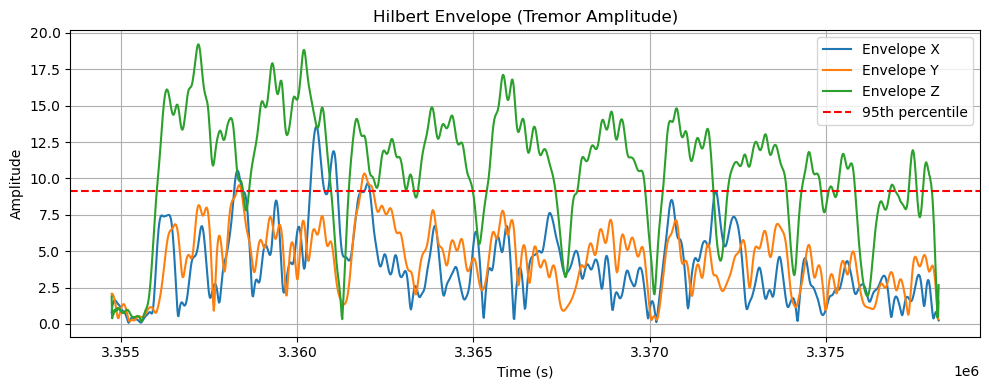

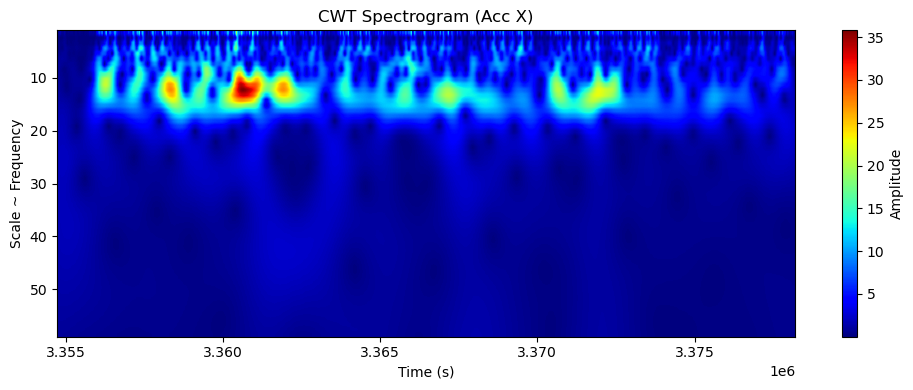

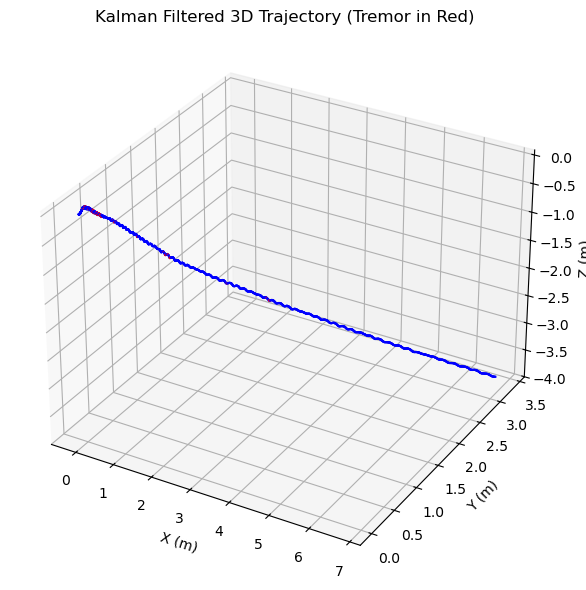

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import butter, filtfilt, hilbert, cwt, morlet2
from scipy.spatial.transform import Rotation as R
from sklearn.decomposition import PCA

# --- Load IMU Data ---
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial2/IMU.h5'
with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    acc = imu['Accelerometer'][:].T
    gyro = imu['Gyroscope'][:].T
    orient = imu['Orientation'][:].T
    time = imu['Timestamp_Sensor'][:] / 1000.0

# --- Constants ---
fs = 60
dt = 1 / fs
N = acc.shape[0]

# --- Rotate acceleration to world frame and remove gravity ---
rot = R.from_euler('xyz', orient, degrees=True)
acc_world = rot.apply(acc)
acc_world -= np.array([0, 0, 9.81])

# --- Band-pass Filter (3-6 Hz tremor band) ---
def bandpass_filter(data, lowcut=1, highcut=6, fs=60, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

tremor_component = bandpass_filter(acc_world)

# --- Hilbert Transform ---
analytic = hilbert(tremor_component, axis=0)
envelope = np.abs(analytic)
phase = np.unwrap(np.angle(analytic), axis=0)
tremor_rms = np.sqrt(np.mean(tremor_component**2, axis=1))

# --- CWT for one axis (acc_x) ---
widths = np.arange(1, 60)
cwt_matrix = cwt(acc_world[:, 0], morlet2, widths, w=5)

# --- Kalman Filter (for position) ---
A = np.block([[np.eye(3), dt*np.eye(3)], [np.zeros((3, 3)), np.eye(3)]])
H = np.block([np.zeros((3, 3)), np.eye(3)])
Q = np.eye(6) * 1e-3
R_kf = np.eye(3) * 1e-2
x = np.zeros((6, 1))
P = np.eye(6) * 0.1
positions_kf = []

for i in range(N):
    acc_i = acc_world[i].reshape(3, 1)
    x = A @ x
    P = A @ P @ A.T + Q
    z = x[3:6] + acc_i * dt
    y = z - H @ x
    S = H @ P @ H.T + R_kf
    K = P @ H.T @ np.linalg.inv(S)
    x = x + K @ y
    P = (np.eye(6) - K @ H) @ P
    positions_kf.append(x[:3].flatten())

positions_kf = np.array(positions_kf)

# --- Identify High Tremor Periods ---
tremor_threshold = np.percentile(tremor_rms, 95)
tremor_mask = tremor_rms > tremor_threshold

# --- Plot: Hilbert Tremor Envelope ---
plt.figure(figsize=(10, 4))
plt.plot(time, envelope[:, 0], label='Envelope X')
plt.plot(time, envelope[:, 1], label='Envelope Y')
plt.plot(time, envelope[:, 2], label='Envelope Z')
plt.axhline(tremor_threshold, color='red', linestyle='--', label='95th percentile')
plt.title('Hilbert Envelope (Tremor Amplitude)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Wavelet Spectrogram ---
plt.figure(figsize=(10, 4))
plt.imshow(np.abs(cwt_matrix), aspect='auto',
           extent=[time[0], time[-1], widths[-1], widths[0]], cmap='jet')
plt.title('CWT Spectrogram (Acc X)')
plt.xlabel('Time (s)')
plt.ylabel('Scale ~ Frequency')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

# --- Plot: Kalman Filtered 3D Trajectory with Tremor Highlight ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
positions_kf = np.array(positions_kf)
colors = np.where(tremor_mask, 'red', 'blue')
for i in range(1, len(positions_kf)):
    ax.plot(positions_kf[i-1:i+1, 0], positions_kf[i-1:i+1, 1],
            positions_kf[i-1:i+1, 2], color=colors[i])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Kalman Filtered 3D Trajectory (Tremor in Red)')
plt.tight_layout()
plt.show()

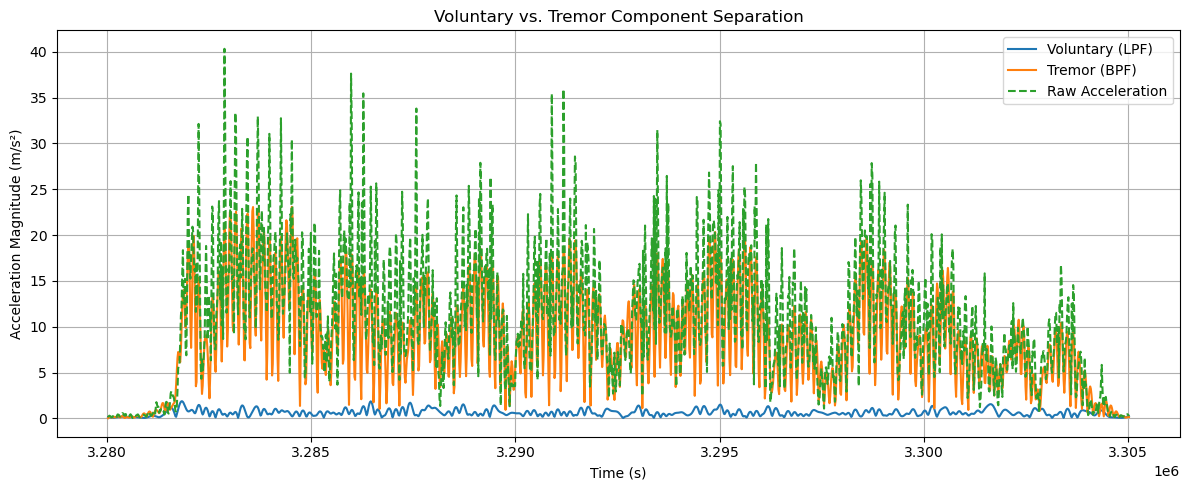

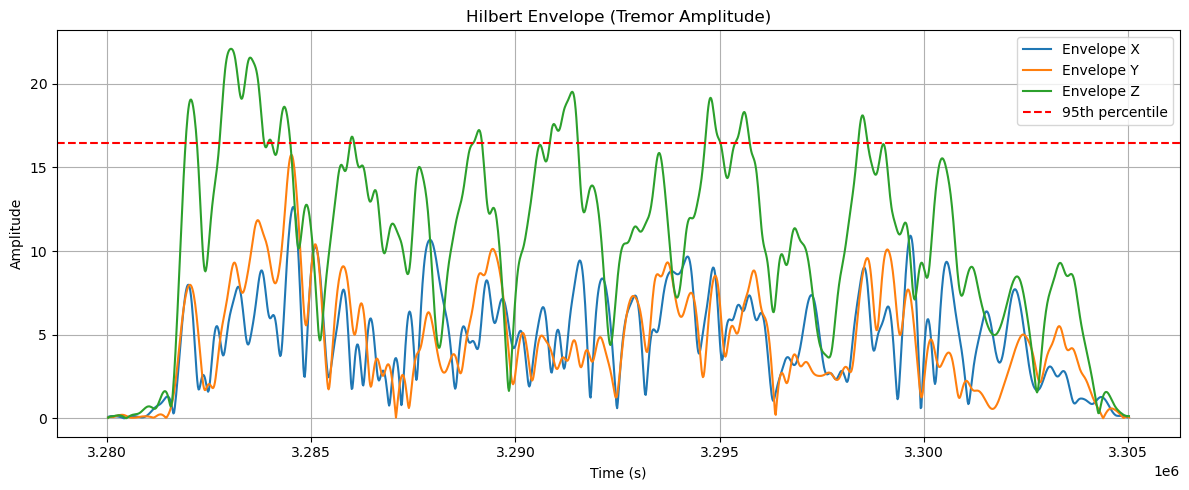

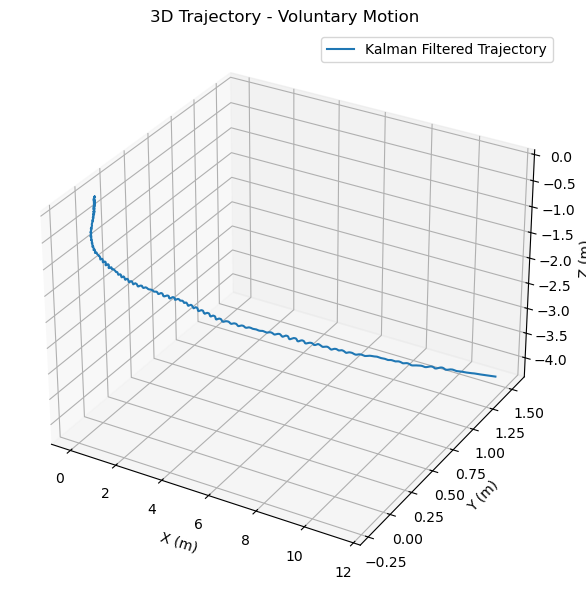

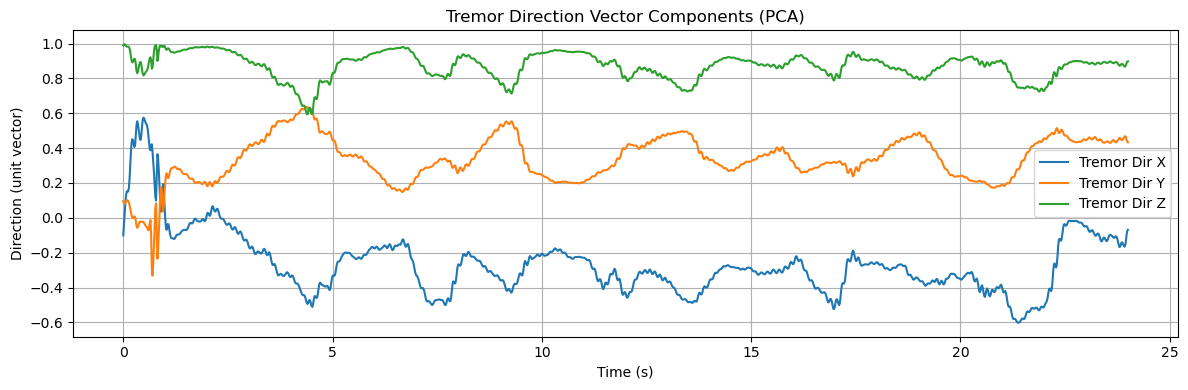

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import butter, filtfilt, hilbert
from scipy.spatial.transform import Rotation as R
from sklearn.decomposition import PCA

# --- Load IMU data ---
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial1/IMU.h5'
with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    acc = imu['Accelerometer'][:].T
    gyro = imu['Gyroscope'][:].T
    orient = imu['Orientation'][:].T
    time = imu['Timestamp_Sensor'][:] / 1000.0

# --- Constants ---
fs = 60
dt = 1 / fs
N = acc.shape[0]

# --- Convert orientation and rotate acceleration to world frame ---
rot = R.from_euler('xyz', orient, degrees=True)
acc_world = rot.apply(acc)
acc_world -= np.array([0, 0, 9.81])

# --- Filters ---
def butter_filter(data, cutoff, fs, order=3, btype='low'):
    nyq = 0.5 * fs
    norm_cutoff = np.array(cutoff) / nyq if isinstance(cutoff, (list, tuple)) else cutoff / nyq
    b, a = butter(order, norm_cutoff, btype=btype)
    return filtfilt(b, a, data, axis=0)

voluntary = butter_filter(acc_world, cutoff=2.0, fs=fs, btype='low')
tremor = butter_filter(acc_world, cutoff=(3.0, 6.0), fs=fs, btype='band')

# --- Hilbert Transform ---
analytic = hilbert(tremor, axis=0)
envelope = np.abs(analytic)
phase = np.unwrap(np.angle(analytic), axis=0)

# --- PCA on Tremor Direction ---
pca = PCA(n_components=1)
window = int(fs * 1.0)
tremor_dir = [pca.fit(tremor[i:i+window]).components_[0] for i in range(N - window)]
tremor_dir = np.array(tremor_dir)

# --- Kalman Filter (for smoothing drift in position estimation) ---
A = np.block([[np.eye(3), dt*np.eye(3)], [np.zeros((3, 3)), np.eye(3)]])
H = np.block([np.zeros((3, 3)), np.eye(3)])
Q = np.eye(6) * 1e-3
R_kf = np.eye(3) * 1e-2
x = np.zeros((6, 1))
P = np.eye(6) * 0.1
positions_kf = []

for i in range(N):
    acc_i = acc_world[i].reshape(3, 1)
    x = A @ x
    P = A @ P @ A.T + Q
    z = x[3:6] + acc_i * dt
    y = z - H @ x
    S = H @ P @ H.T + R_kf
    K = P @ H.T @ np.linalg.inv(S)
    x = x + K @ y
    P = (np.eye(6) - K @ H) @ P
    positions_kf.append(x[:3].flatten())

positions_kf = np.array(positions_kf)

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.plot(time, np.linalg.norm(voluntary, axis=1), label='Voluntary (LPF)')
plt.plot(time, np.linalg.norm(tremor, axis=1), label='Tremor (BPF)')
plt.plot(time, np.linalg.norm(acc_world, axis=1), '--', label='Raw Acceleration')
plt.title('Voluntary vs. Tremor Component Separation')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration Magnitude (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(time, envelope[:, 0], label='Envelope X')
plt.plot(time, envelope[:, 1], label='Envelope Y')
plt.plot(time, envelope[:, 2], label='Envelope Z')
plt.axhline(np.percentile(envelope, 95), color='red', linestyle='--', label='95th percentile')
plt.title('Hilbert Envelope (Tremor Amplitude)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions_kf[:, 0], positions_kf[:, 1], positions_kf[:, 2], label='Kalman Filtered Trajectory')
ax.set_title('3D Trajectory - Voluntary Motion')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()
plt.tight_layout()
plt.show()

# --- Overlay PCA tremor direction if desired ---
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(tremor_dir)) * dt, tremor_dir[:, 0], label='Tremor Dir X')
plt.plot(np.arange(len(tremor_dir)) * dt, tremor_dir[:, 1], label='Tremor Dir Y')
plt.plot(np.arange(len(tremor_dir)) * dt, tremor_dir[:, 2], label='Tremor Dir Z')
plt.title('Tremor Direction Vector Components (PCA)')
plt.xlabel('Time (s)')
plt.ylabel('Direction (unit vector)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/dx/zswlyk812zq8m7h3crzgxx9r0000gn/T/ipykernel_10410/1811887693.py:43: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(acc_world[:, 2], morlet2, widths, w=5)


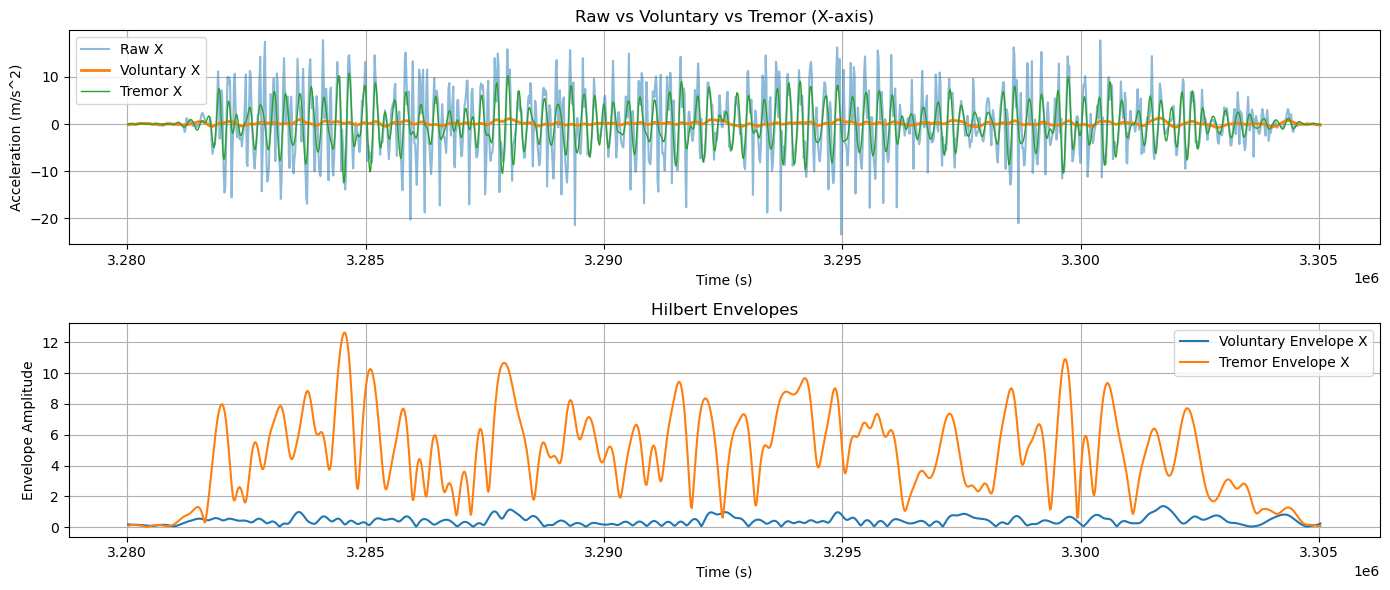

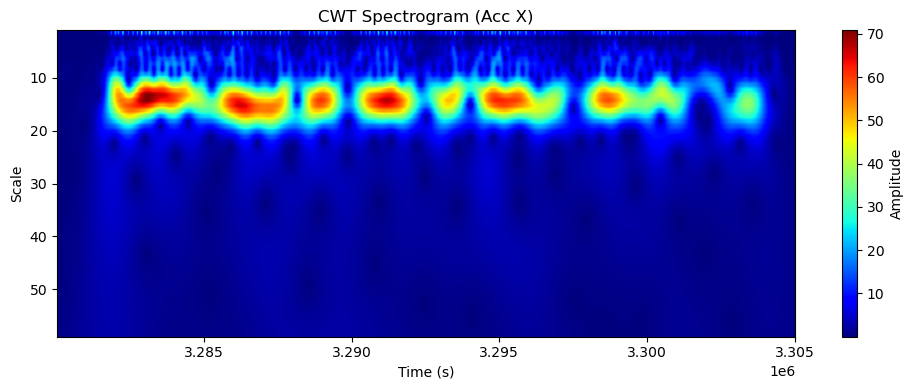

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import butter, filtfilt, hilbert, cwt, morlet2
from scipy.spatial.transform import Rotation as R

# --- Load IMU Data ---
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial1/IMU.h5'
with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    acc = imu['Accelerometer'][:].T
    gyro = imu['Gyroscope'][:].T
    orient = imu['Orientation'][:].T
    time = imu['Timestamp_Sensor'][:] / 1000.0

# --- Constants ---
fs = 60
N = acc.shape[0]
dt = 1 / fs

# --- Rotate to world frame ---
rot = R.from_euler('xyz', orient, degrees=True)
acc_world = rot.apply(acc)
acc_world -= np.array([0, 0, 9.81])

# --- Filter definitions ---
def butter_filter(data, cutoff, fs, btype='low', order=3):
    nyq = 0.5 * fs
    norm_cutoff = np.array(cutoff) / nyq if isinstance(cutoff, (list, tuple)) else cutoff / nyq
    b, a = butter(order, norm_cutoff, btype=btype)
    return filtfilt(b, a, data, axis=0)

# --- Separate voluntary and tremor ---
voluntary = butter_filter(acc_world, cutoff=2.0, fs=fs, btype='low')
tremor = butter_filter(acc_world, cutoff=[3.0, 6.0], fs=fs, btype='band')

# --- Hilbert Envelopes ---
env_voluntary = np.abs(hilbert(voluntary, axis=0))
env_tremor = np.abs(hilbert(tremor, axis=0))

# --- CWT for time-frequency representation ---
widths = np.arange(1, 60)
cwt_matrix = cwt(acc_world[:, 0], morlet2, widths, w=5)

# --- Plot Raw, Filtered, and Envelopes ---
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(time, acc_world[:, 0], label='Raw X', alpha=0.5)
plt.plot(time, voluntary[:, 0], label='Voluntary X', linewidth=2)
plt.plot(time, tremor[:, 0], label='Tremor X', linewidth=1)
plt.title('Raw vs Voluntary vs Tremor (X-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, env_voluntary[:, 0], label='Voluntary Envelope X')
plt.plot(time, env_tremor[:, 0], label='Tremor Envelope X')
plt.xlabel('Time (s)')
plt.ylabel('Envelope Amplitude')
plt.title('Hilbert Envelopes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- CWT Spectrogram ---
plt.figure(figsize=(10, 4))
plt.imshow(np.abs(cwt_matrix), aspect='auto', extent=[time[0], time[-1], widths[-1], widths[0]], cmap='jet')
plt.title('CWT Spectrogram (Acc X)')
plt.xlabel('Time (s)')
plt.ylabel('Scale')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()


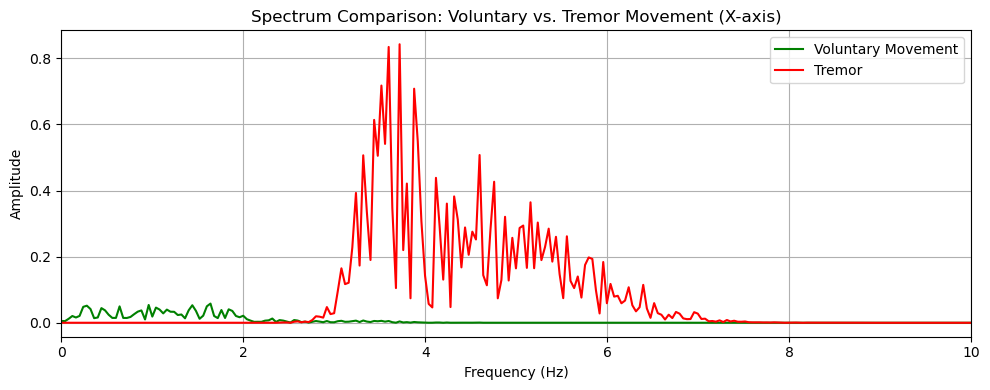

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

def bandpass(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply bandpass filters
voluntary = bandpass(acc_world, 0.1, 2.0, fs)   # low-frequency voluntary
tremor = bandpass(acc_world, 3.0, 6.0, fs)      # typical tremor band

# Compute FFT
def compute_fft(signal, fs):
    N = signal.shape[0]
    freqs = fftfreq(N, 1/fs)
    mag = np.abs(fft(signal, axis=0)) / N
    return freqs[:N//2], mag[:N//2]

freqs_v, mag_v = compute_fft(voluntary[:, 0], fs)  # e.g. X-axis
freqs_t, mag_t = compute_fft(tremor[:, 0], fs)

# Plot spectra
plt.figure(figsize=(10, 4))
plt.plot(freqs_v, mag_v, label='Voluntary Movement', color='green')
plt.plot(freqs_t, mag_t, label='Tremor', color='red')
plt.title('Spectrum Comparison: Voluntary vs. Tremor Movement (X-axis)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


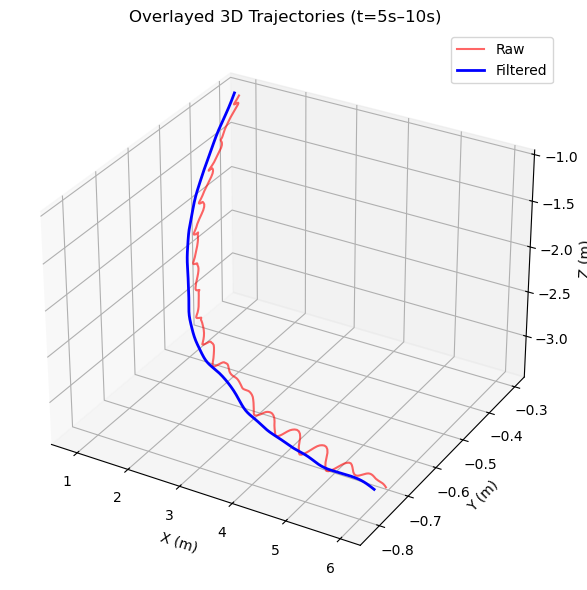

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt

# --- Load IMU data ---
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial1/IMU.h5'
with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    acc = imu['Accelerometer'][:].T        # shape (N, 3)
    gyro = imu['Gyroscope'][:].T           # shape (N, 3)
    orient = imu['Orientation'][:].T       # Euler angles in degrees
    time = imu['Timestamp_Sensor'][:] / 1000.0  # Convert from ms to seconds

# --- Parameters ---
fs = 60  # Sampling rate in Hz
dt = 1 / fs
N = acc.shape[0]

# --- Convert orientation to world frame acceleration ---
rot = R.from_euler('xyz', orient, degrees=True)
acc_world = rot.apply(acc)  # Rotate to world frame
acc_world -= np.array([0, 0, 9.81])  # Subtract gravity

# --- Optional: Low-pass filter to remove tremor ---
def lowpass_filter(data, cutoff=2.0, fs=60, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, data, axis=0)

acc_filtered = lowpass_filter(acc_world, cutoff=2.0, fs=fs)

# --- Integrate acceleration to get velocity and position ---
velocity_raw = np.cumsum(acc_world * dt, axis=0)
position_raw = np.cumsum(velocity_raw * dt, axis=0)

velocity_filt = np.cumsum(acc_filtered * dt, axis=0)
position_filt = np.cumsum(velocity_filt * dt, axis=0)

# --- Select 5-second segment starting at 5 seconds ---
start_t = 5
duration = 5
start_idx = int(start_t * fs)
end_idx = start_idx + int(duration * fs)

pos_raw_seg = position_raw[start_idx:end_idx]
pos_filt_seg = position_filt[start_idx:end_idx]

# --- 3D Plot: Overlay raw vs filtered trajectory segment ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_raw_seg[:, 0], pos_raw_seg[:, 1], pos_raw_seg[:, 2], label='Raw', color='red', alpha=0.6)
ax.plot(pos_filt_seg[:, 0], pos_filt_seg[:, 1], pos_filt_seg[:, 2], label='Filtered', color='blue', linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title(f'Overlayed 3D Trajectories (t={start_t}s–{start_t+duration}s)')
ax.legend()
plt.tight_layout()
plt.show()


In [74]:
# plt IMU keys
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial1/IMU.h5'
with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    print("IMU Keys:")
    for key in imu.keys():
        print(f" - {key}")

IMU Keys:
 - Accelerometer
 - Gyroscope
 - Orientation
 - Quaternion
 - SeqID
 - Timestamp_Sensor
 - Timestamp_System


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import butter, filtfilt
from ahrs.filters import Madgwick
from ahrs.common.orientation import q2R

# --- Load IMU data ---
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial1/IMU.h5'
with h5py.File(path, 'r') as file:
    imu = file['IMU']['DOT_40195BFD802900B5']
    acc = imu['Accelerometer'][:].T         # shape (N, 3)
    gyro = imu['Gyroscope'][:].T            # shape (N, 3)
    mag = imu['Magnetometer'][:].T          # shape (N, 3)
    time = imu['Timestamp_Sensor'][:] / 1000.0  # Convert from ms to seconds

# --- Sampling setup ---
fs = 60  # Hz
dt = 1 / fs
N = acc.shape[0]

# --- Orientation estimation using Madgwick filter ---
madgwick = Madgwick(sampleperiod=dt)
quaternions = np.zeros((N, 4))
quaternions[0] = [1.0, 0.0, 0.0, 0.0]  # Initial quaternion

for t in range(1, N):
    quaternions[t] = madgwick.updateIMU(quaternions[t-1], gyr=gyro[t], acc=acc[t])

# --- Rotate acceleration to global frame ---
acc_world = np.zeros_like(acc)
for i in range(N):
    R_i = q2R(quaternions[i])
    acc_world[i] = R_i @ acc[i]

# --- Remove gravity ---
acc_world -= np.array([0, 0, 9.81])

# --- Optional: low-pass filter to remove tremor ---
def lowpass_filter(data, cutoff=2.0, fs=60, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, data, axis=0)

acc_filtered = acc_world  # Or use: lowpass_filter(acc_world)

# --- Integrate acceleration to velocity and position ---
velocity = np.cumsum(acc_filtered * dt, axis=0)
position = np.cumsum(velocity * dt, axis=0)

# --- Plot 3D trajectory ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(position[:, 0], position[:, 1], position[:, 2], label='3D Trajectory')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Sensor-Fused 3D Movement Trajectory')
ax.legend()
plt.tight_layout()
plt.show()


KeyError: "Unable to open object (object 'Magnetometer' doesn't exist)"

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend

def ekf_frequency_estimation(y, fs, q=1e-5, r=1e-1, init_freq=2.0):
    """
    Extended Kalman Filter to estimate instantaneous frequency and amplitude of a sinusoidal signal.
    
    Parameters:
        y (np.ndarray): 1D array of signal values.
        fs (float): Sampling frequency in Hz.
        q (float): Process noise variance.
        r (float): Observation noise variance.
        init_freq (float): Initial guess for frequency (Hz).
        
    Returns:
        amp_est (np.ndarray): Estimated amplitude over time.
        freq_est (np.ndarray): Estimated frequency over time.
    """
    n = len(y)
    dt = 1 / fs
    x = np.zeros((3, n))  # State: [amplitude, phase, frequency]
    x[:, 0] = [np.std(y), 0, 2 * np.pi * init_freq]
    
    P = np.eye(3) * 0.1
    Q = np.diag([q, q, q])
    R = r

    for k in range(1, n):
        # Prediction
        A = x[0, k - 1]
        phi = x[1, k - 1]
        omega = x[2, k - 1]

        x_pred = np.array([
            A,
            phi + omega * dt,
            omega
        ])

        # Jacobian of the dynamics
        F = np.array([
            [1, 0, 0],
            [0, 1, dt],
            [0, 0, 1]
        ])

        P = F @ P @ F.T + Q

        # Measurement prediction
        h = x_pred[0] * np.sin(x_pred[1])
        H = np.array([
            [np.sin(x_pred[1]), x_pred[0] * np.cos(x_pred[1]), 0]
        ])

        y_pred = h
        S = H @ P @ H.T + R
        K = P @ H.T / S
        residual = y[k] - y_pred
        x[:, k] = x_pred + (K.flatten() * residual)
        P = (np.eye(3) - K @ H) @ P

    amp_est = x[0]
    freq_est = x[2] / (2 * np.pi)
    return amp_est, freq_est

# Example usage:
def run_ekf_on_acceleration(acc, fs):
    """
    Run EKF on 3-axis accelerometer data.
    
    Parameters:
        acc (np.ndarray): Accelerometer data of shape (3, N).
        fs (float): Sampling frequency in Hz.
    """
    time = np.arange(acc.shape[1]) / fs
    fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
    axes = ['X', 'Y', 'Z']
    amp_all = []
    freq_all = []
    for i in range(3):
        y = detrend(acc[i])
        amp_est, freq_est = ekf_frequency_estimation(y, fs)
        amp_all.append(amp_est)
        freq_all.append(freq_est)
    

        axs[i, 0].plot(time, amp_est)
        axs[i, 0].set_ylabel(f"Amp ({axes[i]})")
        axs[i, 0].grid(True)

        axs[i, 1].plot(time, freq_est)
        axs[i, 1].set_ylabel(f"Freq ({axes[i]})")
        axs[i, 1].grid(True)

    axs[2, 0].set_xlabel("Time (s)")
    axs[2, 1].set_xlabel("Time (s)")
    axs[0, 0].set_title("Estimated Amplitude")
    axs[0, 1].set_title("Estimated Frequency (Hz)")
    plt.tight_layout()
    plt.show()
    return np.array(freq_all), np.array(amp_all)


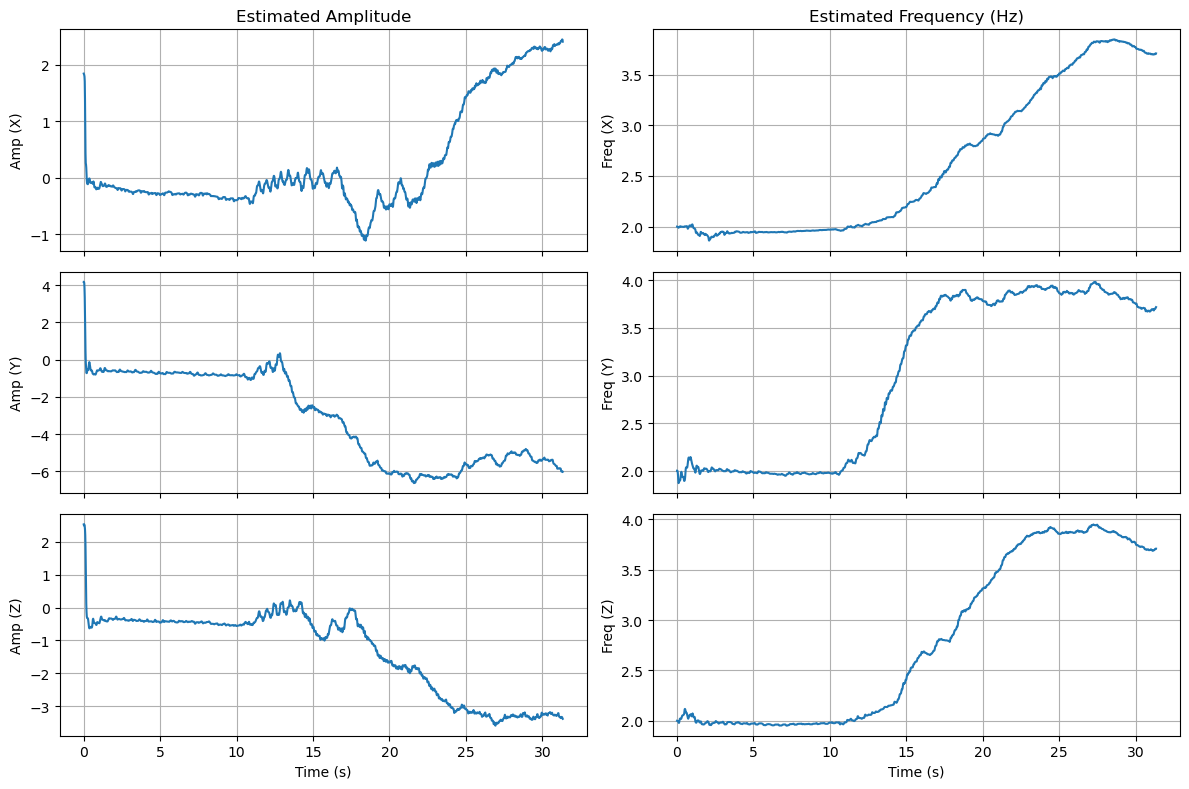

In [15]:
amps,freqs = run_ekf_on_acceleration(acc, 60)

In [16]:
import numpy as np

def kalman_filter_bank_spectrogram(signal, fs, freqs, q=1e-4, r=1e-1):
    """
    Apply a bank of Kalman filters across frequencies and time.

    Parameters:
        signal (np.ndarray): 1D signal (length N)
        fs (float): Sampling rate in Hz
        freqs (np.ndarray): Array of frequencies to evaluate
        q (float): Process noise
        r (float): Observation noise

    Returns:
        np.ndarray: Spectrogram-like power matrix (len(freqs) x len(signal))
    """
    N = len(signal)
    dt = 1 / fs
    spec = np.zeros((len(freqs), N))

    for i, f in enumerate(freqs):
        omega = 2 * np.pi * f
        x = np.zeros(2)
        P = np.eye(2)
        Q = q * np.eye(2)
        R = r

        for k in range(N):
            H = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
            y = signal[k]

            x_pred = x
            P_pred = P + Q

            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T / S
            x = x_pred + (K.flatten() * (y - H @ x_pred)).flatten()
            P = (np.eye(2) - K @ H) @ P_pred

            spec[i, k] = np.sum(x ** 2)

    return spec

import matplotlib.pyplot as plt

def plot_kalman_spectrogram(spec, freqs, fs, title='Kalman Filter Spectrogram'):
    spec = spec / (np.max(spec, axis=0, keepdims=True) + 1e-10)  # avoid division by zero

    t = np.arange(spec.shape[1]) / fs  # Time axis

    plt.figure(figsize=(12, 5))
    vmin = np.percentile(spec, 5)
    vmax = np.percentile(spec, 95)  # or 99 if fewer outliers

    plt.imshow(
        spec,
        extent=[t[0], t[-1], freqs[0], freqs[-1]],
        aspect='auto',
        origin='lower',
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    # #add red line with y=max power at that timepoint
    # max_power_indices = np.argmax(spec, axis=0)
    # max_power_freqs = freqs[max_power_indices]
    # #plt.plot(t, max_power_freqs, color='red', linewidth=2, label='Max Power Frequency')


    # #add red line at normalized power > 0.5 and lowest frequency
    # normalized_power = spec
    # low_freq_indices = np.where(normalized_power < 0.5)[0]
    # low_freqs = freqs[low_freq_indices]
    # plt.plot(t, low_freqs, color='red', linewidth=2, label='Low Frequency Power')
    # Find lowest frequency with power > threshold at each timepoint
    threshold = 0.5
    fundamental_freqs = []
    for k in range(spec.shape[1]):
        power_col = spec[:, k]
        high_power_indices = np.where(power_col > threshold)[0]
        if len(high_power_indices) > 0:
            f_lowest = freqs[high_power_indices[0]]  # first = lowest frequency
        else:
            f_lowest = np.nan
        fundamental_freqs.append(f_lowest)

    fundamental_freqs = np.array(fundamental_freqs)
    plt.plot(t, fundamental_freqs, color='red', linewidth=2, label='Estimated Fundamental (P > 0.5)')



   

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.colorbar(label='Power')
    plt.tight_layout()
    plt.show()



In [17]:
import numpy as np
from scipy.signal import butter, filtfilt, detrend

def preprocess_signal(signal, fs, hp_cutoff=1.0, order=4):
    """
    Apply high-pass filtering and detrending to the signal.

    Parameters:
        signal (np.ndarray): 1D or 2D signal array (channels x time or time).
        fs (float): Sampling frequency in Hz.
        hp_cutoff (float): High-pass filter cutoff frequency in Hz.
        order (int): Filter order.

    Returns:
        np.ndarray: Preprocessed signal (same shape as input).
    """
    def highpass(sig):
        b, a = butter(order, hp_cutoff / (0.5 * fs), btype='high')
        return filtfilt(b, a, sig)

    # Apply detrending then high-pass filter
    if signal.ndim == 1:
        signal = detrend(signal)
        signal = highpass(signal)
    elif signal.ndim == 2:
        for i in range(signal.shape[0]):
            signal[i] = detrend(signal[i])
            signal[i] = highpass(signal[i])
    else:
        raise ValueError("Signal must be 1D or 2D (channels x time)")

    return signal


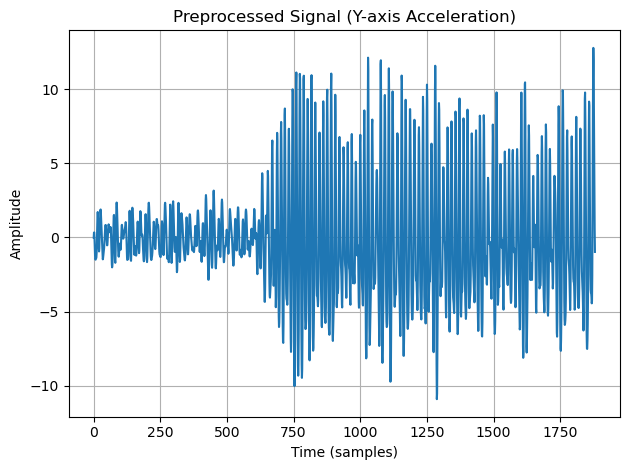

Change point detected at sample index: 757
Change point in signal: 757 (sample index)


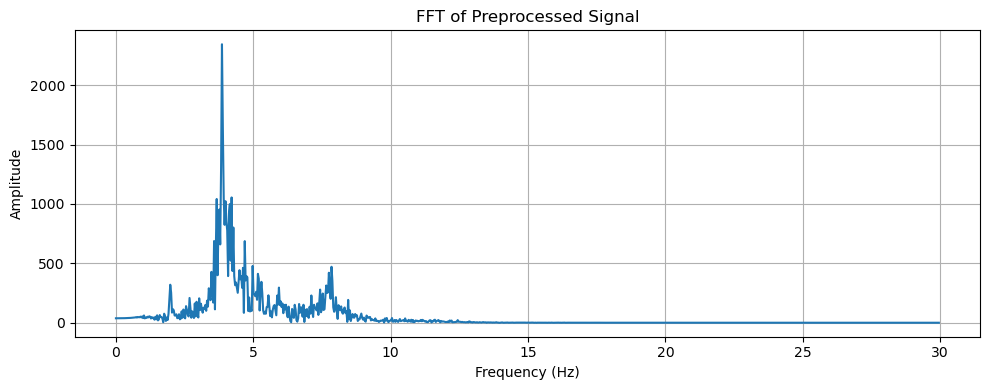

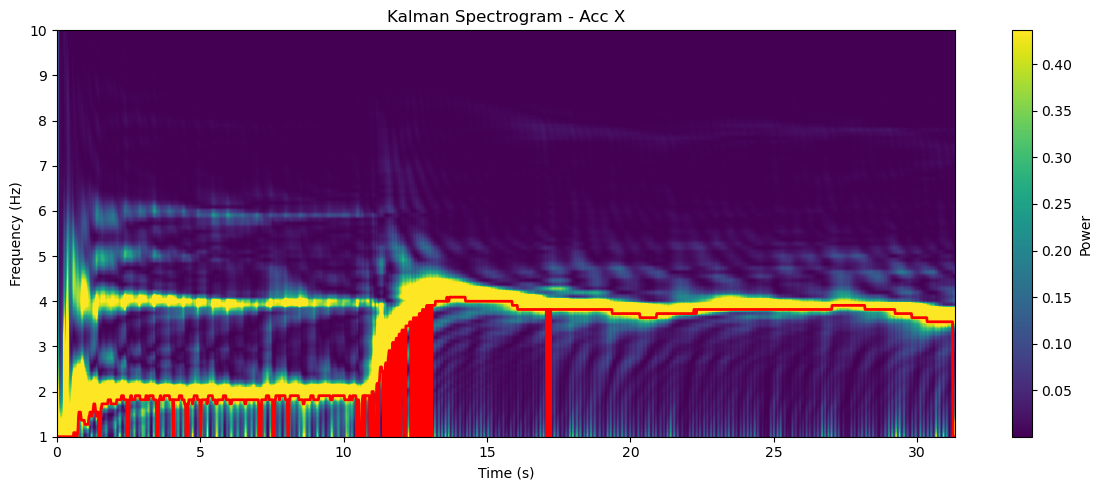

In [27]:
fs = 60  # or use 1 / np.mean(np.diff(time)) if available
freqs = np.linspace(1, 10, 100)  # 1–10 Hz, 100 bins
preprocessed_signal = preprocess_signal(acc[1], fs)  # Preprocess Y-axis accelerometer data
#preprocessed_signal = preprocessed_signal[:600]
plt.plot(preprocessed_signal)

plt.title("Preprocessed Signal (Y-axis Acceleration)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()
#determine frequency change points
import numpy as np
# Find change points in the preprocessed signal
from scipy.signal import find_peaks
# Find peaks in the absolute difference of the signal
peaks, _ = find_peaks(np.abs(np.diff(preprocessed_signal)), height=5)
# Find change points based on peaks
change_point = peaks[0] if len(peaks) > 0 else None
if change_point is not None:
    print(f"Change point detected at sample index: {change_point}")
else:
    print("No change point detected in the signal.")

print(f"Change point in signal: {change_point} (sample index)")
# Plot the change point

#fft 

fft_vals = np.abs(fft(preprocessed_signal))
freqs_fft = fftfreq(len(preprocessed_signal), 1/fs)
plt.figure(figsize=(10, 4))
plt.plot(freqs_fft[:len(freqs_fft)//2], fft_vals[:len(freqs_fft)//2])
plt.title("FFT of Preprocessed Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()
spec_x = kalman_filter_bank_spectrogram(preprocessed_signal, fs, freqs)
plot_kalman_spectrogram(spec_x, freqs, fs, title='Kalman Spectrogram - Acc X')


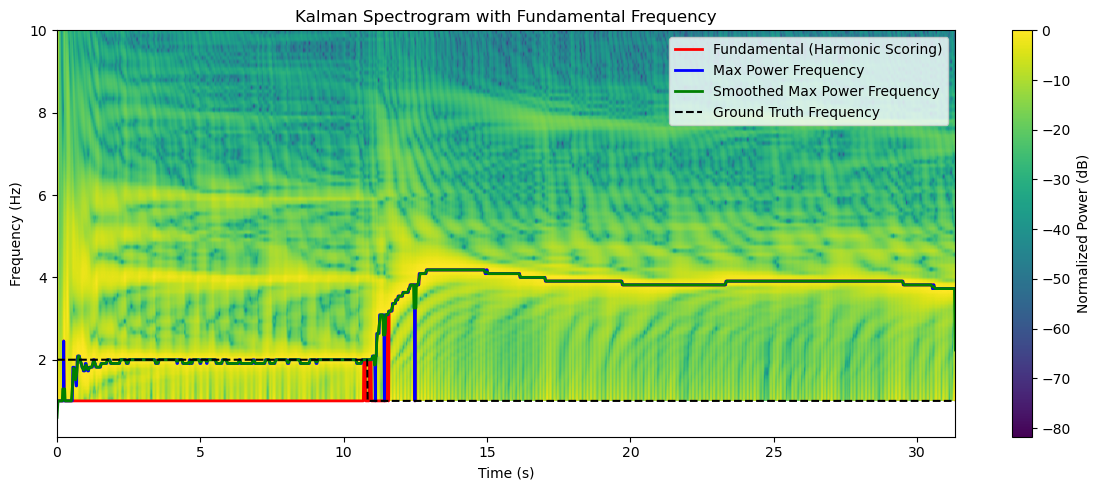

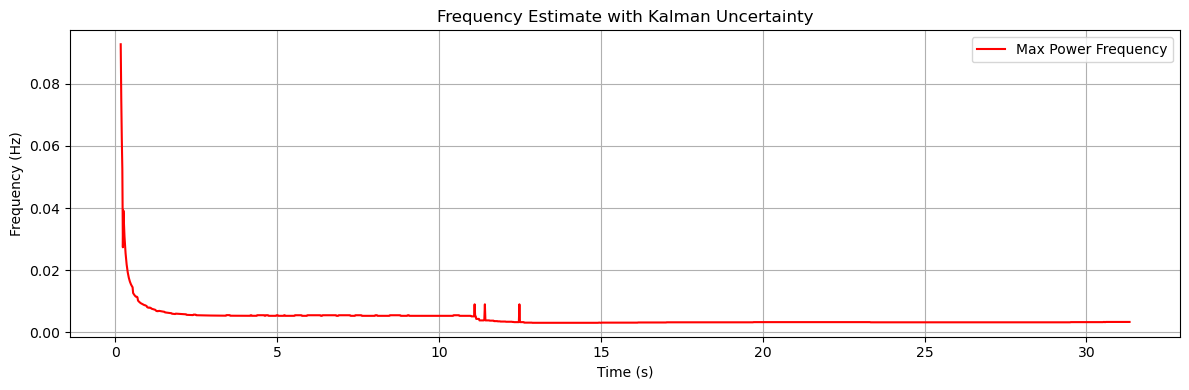

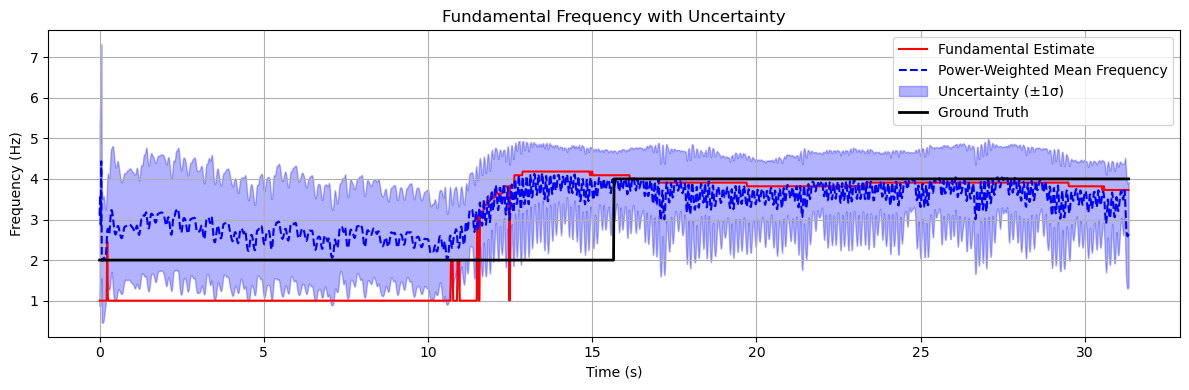

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# --- 1. Preprocessing function ---
def preprocess_signal(signal, fs, lowcut=1.0, highcut=10.0):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, [low, high], btype='band')
    return filtfilt(b, a, signal)

# --- 2. Updated Kalman filter bank ---
def kalman_filter_bank_spectrogram(signal, fs, freqs, q=1e-4, r=1e-1,
                                   power_bias=1.5, process_noise_bias=1.5):
    N = len(signal)
    dt = 1 / fs
    spec = np.zeros((len(freqs), N))
    uncertainty = np.zeros((len(freqs), N))

    for i, f in enumerate(freqs):
        omega = 2 * np.pi * f
        x = np.zeros(2)
        P = np.eye(2)
        Q = (q / (f**process_noise_bias)) * np.eye(2)
        R = r

        for k in range(N):
            H = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
            y = signal[k]

            x_pred = x
            P_pred = P + Q

            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T / S
            x = x_pred + (K.flatten() * (y - H @ x_pred)).flatten()
            P = (np.eye(2) - K @ H) @ P_pred

            power = np.sum(x ** 2) / (f**power_bias)
            spec[i, k] = power
            uncertainty[i, k] = np.trace(P)  # total state uncertainty

    return spec, uncertainty


# --- 3. Harmonic-based fundamental frequency detection ---
def harmonic_score_column(spec_col, freqs, max_harmonics=4, threshold=0.5):
    scores = []
    f_max = freqs[-1]

    for i, f in enumerate(freqs):
        harmonics = []
        for h in range(1, max_harmonics + 1):
            f_h = f * h
            if f_h > f_max:
                continue
            idx = np.argmin(np.abs(freqs - f_h))
            if idx < len(spec_col) and spec_col[idx] > threshold:
                harmonics.append(spec_col[idx] / h**2)
        scores.append(np.sum(harmonics) if harmonics else 0.0)

    return scores

def extract_fundamental_from_spec(spec, freqs, fs, max_harmonics=4, threshold=0.5):
    fundamental_freqs = []
    for k in range(spec.shape[1]):
        spec_col = spec[:, k]
        scores = harmonic_score_column(spec_col, freqs, max_harmonics=max_harmonics, threshold=threshold)
        best_idx = np.argmax(scores)
        fundamental_freqs.append(freqs[best_idx])
    return np.array(fundamental_freqs)

# --- 4. Plotting ---
def plot_kalman_spectrogram_with_fundamental(spec, freqs, fs, fundamental_freqs, title='Kalman Spectrogram with Fundamental'):
    t = np.arange(spec.shape[1]) / fs
    spec_db = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

    plt.figure(figsize=(12, 5))
    plt.imshow(spec_db, extent=[t[0], t[-1], freqs[0], freqs[-1]],
               aspect='auto', origin='lower', cmap='viridis')
    plt.plot(t, fundamental_freqs, color='red', linewidth=2, label='Fundamental (Harmonic Scoring)')
    #plot freq qith max power at that timepoint
    max_power_indices = np.argmax(spec, axis=0)
    max_power_freqs = freqs[max_power_indices]
    plt.plot(t, max_power_freqs, color='blue', linewidth=2, label='Max Power Frequency')
    #smoothed max power over time
    smoothed_max_power_freqs = np.convolve(max_power_freqs, np.ones(5)/5, mode='same')
    plt.plot(t, smoothed_max_power_freqs, color='green', linewidth=2, label='Smoothed Max Power Frequency')

    ground_truth_freqs = np.ones(len(t))  # Example ground truth frequencies
    ground_truth_freqs[:650] = ground_truth_freqs[:650]*2.0  # First 650 samples at 2 Hz
    plt.plot(t, ground_truth_freqs, color='black', linestyle='--', label='Ground Truth Frequency')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.colorbar(label='Normalized Power (dB)')
    plt.legend()
    plt.tight_layout()
    plt.show()
fs = 60  # Sampling frequency
preprocessed = preprocess_signal(acc[1], fs)  # Preprocess Y-axis accelerometer data
freq_grid = np.linspace(1, 10, 100)  # 1–10 Hz, 100 bins
spec, uncertainty = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid, power_bias=1.5, process_noise_bias=1.5)

fundamental_freqs = extract_fundamental_from_spec(spec, freq_grid, fs, max_harmonics=4, threshold=0.5)
plot_kalman_spectrogram_with_fundamental(spec, freq_grid, fs, fundamental_freqs, title='Kalman Spectrogram with Fundamental Frequency')
#spec, uncertainty = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid)

max_power_indices = np.argmax(spec, axis=0)
uncertainty_trace = uncertainty[max_power_indices, np.arange(spec.shape[1])]
t = np.arange(spec.shape[1]) / fs
max_freqs = freq_grid[max_power_indices]



plt.figure(figsize=(12, 4))
plt.plot(t[10:], uncertainty_trace[10:], 'r-', label='Max Power Frequency')

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.title('Frequency Estimate with Kalman Uncertainty')
plt.tight_layout()
plt.grid(True)
plt.show()


def compute_frequency_uncertainty(spec, freqs):
    """
    Compute frequency uncertainty as the power-weighted standard deviation
    for each timepoint.
    """
    spec_sum = np.sum(spec, axis=0, keepdims=True) + 1e-10  # normalize to avoid divide-by-zero
    weights = spec / spec_sum
    mean_freqs = np.sum(weights * freqs[:, None], axis=0)
    var_freqs = np.sum(weights * (freqs[:, None] - mean_freqs[None, :])**2, axis=0)
    stddev_freqs = np.sqrt(var_freqs)
    return mean_freqs, stddev_freqs

def plot_with_uncertainty(t, fundamental_freqs, mean_freqs, stddev_freqs, ground_truth=None):
    """
    Plot estimated frequencies with uncertainty bands.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(t, fundamental_freqs, 'r-', label='Fundamental Estimate')
    plt.plot(t, mean_freqs, 'b--', label='Power-Weighted Mean Frequency')
    plt.fill_between(t, mean_freqs - stddev_freqs, mean_freqs + stddev_freqs,
                     color='blue', alpha=0.3, label='Uncertainty (±1σ)')
    if ground_truth is not None:
        plt.plot(t, ground_truth, 'k-', linewidth=2, label='Ground Truth')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Fundamental Frequency with Uncertainty')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


t = np.arange(spec.shape[1]) / fs
mean_freqs, stddev_freqs = compute_frequency_uncertainty(spec, freq_grid)

# Optional: generate ground truth (e.g., 2 Hz for 0–10s, 4 Hz after)
ground_truth = np.ones_like(t) * 2
ground_truth[int(len(t)//2):] = 4

plot_with_uncertainty(t, fundamental_freqs, mean_freqs, stddev_freqs, ground_truth)



In [37]:
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_kalman_spectrogram(spec, freqs, fs, interval=100, smooth_window=5):
    t = np.arange(spec.shape[1]) / fs
    spec_db_full = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))
    spec_db = np.full_like(spec_db_full, np.nan)

    true_freq = np.ones_like(t) * 2
    true_freq[650:] = 4

    max_power_indices = np.argmax(spec, axis=0)
    max_power_freqs = freqs[max_power_indices]
    smoothed_max_power = np.convolve(max_power_freqs, np.ones(smooth_window)/smooth_window, mode='same')

    # Create masked array for proper display of NaNs
    fig, ax = plt.subplots(figsize=(12, 5))
    cmap = plt.get_cmap('viridis').copy()
    cmap.set_bad(color='white')  # show NaNs as black
    spec_masked = np.ma.masked_invalid(spec_db)
    img = ax.imshow(spec_masked, extent=[t[0], t[-1], freqs[0], freqs[-1]],
                    aspect='auto', origin='lower', cmap=cmap,
                    vmin=np.nanmin(spec_db_full), vmax=np.nanmax(spec_db_full))

    line_true, = ax.plot([], [], 'k-', linewidth=2, label='Ground Truth (2→4 Hz)')
    line_max, = ax.plot([], [], 'r-', linewidth=1.5, label='Max Power Frequency')
    line_smooth, = ax.plot([], [], 'b-', linewidth=1.5, label='Smoothed Max Power')

    ax.set_xlim(t[0], t[-1])
    ax.set_ylim(freqs[0], freqs[-1])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title('Kalman Spectrogram (Progressive Reveal)')
    ax.legend()
    fig.colorbar(img, ax=ax, label='Normalized Power (dB)')

    def update(frame):
        spec_db[:, frame] = spec_db_full[:, frame]  # reveal one column
        img.set_data(np.ma.masked_invalid(spec_db))  # refresh masked data

        line_true.set_data(t[:frame+1], true_freq[:frame+1])
        line_max.set_data(t[:frame+1], max_power_freqs[:frame+1])
        line_smooth.set_data(t[:frame+1], smoothed_max_power[:frame+1])

        return img, line_true, line_max, line_smooth

    ani = animation.FuncAnimation(fig, update, frames=range(1, spec.shape[1]), interval=interval, blit=True)
    plt.close(fig)
    return ani


# --- 5. Animated video simulation of real-time estimation ---
# def animate_kalman_spectrogram(spec, freqs, fs, fundamental_freqs, interval=100):
#     """
#     Animate the Kalman spectrogram with evolving fundamental frequency and ground truth overlay.
#     """
#     t = np.arange(spec.shape[1]) / fs
#     spec_db = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

#     # Ground truth frequency: 2 Hz for first 600 points, 4 Hz for the rest
#     true_freq = np.ones_like(t) * 2
#     true_freq[650:] = 4

#     # Max power frequency per timepoint
#     max_power_indices = np.argmax(spec, axis=0)
#     max_power_freqs = freqs[max_power_indices]
#     smoothed_max_power = np.convolve(max_power_freqs, np.ones(5)/5, mode='same')

#     fig, ax = plt.subplots(figsize=(12, 5))
#     img = ax.imshow(spec_db[:, :1], extent=[t[0], t[0], freqs[0], freqs[-1]],
#                     aspect='auto', origin='lower', cmap='viridis',
#                     vmin=np.min(spec_db), vmax=np.max(spec_db))

#     line_true, = ax.plot([], [], 'k-', linewidth=2, label='Ground Truth (2→4 Hz)')
#     line_max, = ax.plot([], [], 'r-', linewidth=1.5, label='Max Power Frequency')
#     line_smooth, = ax.plot([], [], 'b-', linewidth=1.5, label='Smoothed Max Power')

#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Frequency (Hz)')
#     ax.set_title('Kalman Spectrogram (Streaming Simulation)')
#     ax.legend()
#     fig.colorbar(img, ax=ax, label='Normalized Power (dB)')

#     def update(frame):
#         img.set_data(spec_db[:, :frame+1])
#         img.set_extent([t[0], t[frame], freqs[0], freqs[-1]])

#         line_true.set_data(t[:frame+1], true_freq[:frame+1])
#         line_max.set_data(t[:frame+1], max_power_freqs[:frame+1])
#         line_smooth.set_data(t[:frame+1], smoothed_max_power[:frame+1])

#         return img, line_true, line_max, line_smooth

#     ani = animation.FuncAnimation(fig, update, frames=range(1, spec.shape[1]), interval=interval, blit=True)
#     plt.close(fig)
#     return ani

# Create and show the animation
#ani = animate_kalman_spectrogram(spec, freq_grid, fs, fundamental_freqs)

# --- Prepare signal ---
preprocessed = preprocess_signal(acc[1], fs)
freq_grid = np.linspace(1, 10, 100)

# --- Kalman spectrogram and fundamental frequency ---
spec = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid, power_bias=1.5, process_noise_bias=1.5)
fundamental_freqs = extract_fundamental_from_spec(spec, freq_grid, fs, max_harmonics=4, threshold=0.5)

# --- Animate ---
ani = animate_kalman_spectrogram(spec, freq_grid, fs,)
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 500  # in MB
from matplotlib.animation import PillowWriter

ani.save("kalman_spectrogram.gif", writer=PillowWriter(fps=30))
print("Saved to disk successfully.")

#HTML(ani.to_jshtml())


Saved to disk successfully.


In [ ]:
import matplotlib.animation as animation

# --- 5. Animated video simulation of real-time estimation ---
def animate_kalman_spectrogram(spec, freqs, fs, fundamental_freqs, interval=100):
    """
    Animate the Kalman spectrogram with evolving fundamental frequency.
    """
    t = np.arange(spec.shape[1]) / fs
    spec_db = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

    fig, ax = plt.subplots(figsize=(12, 5))
    img = ax.imshow(spec_db[:, :1], extent=[t[0], t[0], freqs[0], freqs[-1]],
                    aspect='auto', origin='lower', cmap='viridis', vmin=np.min(spec_db), vmax=np.max(spec_db))

    line_fund, = ax.plot([], [], 'r-', linewidth=2, label='Fundamental (Harmonic Scoring)')
    line_max, = ax.plot([], [], 'b-', linewidth=1, label='Max Power Frequency')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title('Kalman Spectrogram (Streaming Simulation)')
    ax.legend()
    fig.colorbar(img, ax=ax, label='Normalized Power (dB)')

    def update(frame):
        img.set_data(spec_db[:, :frame+1])
        img.set_extent([t[0], t[frame], freqs[0], freqs[-1]])

        line_fund.set_data(t[:frame+1], fundamental_freqs[:frame+1])
        max_power_indices = np.argmax(spec[:, :frame+1], axis=0)
        max_power_freqs = freqs[max_power_indices]
        line_max.set_data(t[:frame+1], max_power_freqs)

        return img, line_fund, line_max

    ani = animation.FuncAnimation(fig, update, frames=range(1, spec.shape[1]), interval=interval, blit=True)
    plt.close(fig)
    return ani

# Create and show the animation
#ani = animate_kalman_spectrogram(spec, freq_grid, fs, fundamental_freqs)

# --- Prepare signal ---
preprocessed = preprocess_signal(acc[1], fs)
freq_grid = np.linspace(1, 10, 100)

# --- Kalman spectrogram and fundamental frequency ---
spec = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid, power_bias=1.5, process_noise_bias=1.5)
fundamental_freqs = extract_fundamental_from_spec(spec, freq_grid, fs, max_harmonics=4, threshold=0.5)

# --- Animate ---
ani = animate_kalman_spectrogram(spec, freq_grid, fs, fundamental_freqs)
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 500  # in MB
ani.save('kalman_spectrogram.mp4', writer='ffmpeg', fps=10)
print("Saved to disk successfully.")

HTML(ani.to_jshtml())


NameError: name 'preprocess_signal' is not defined

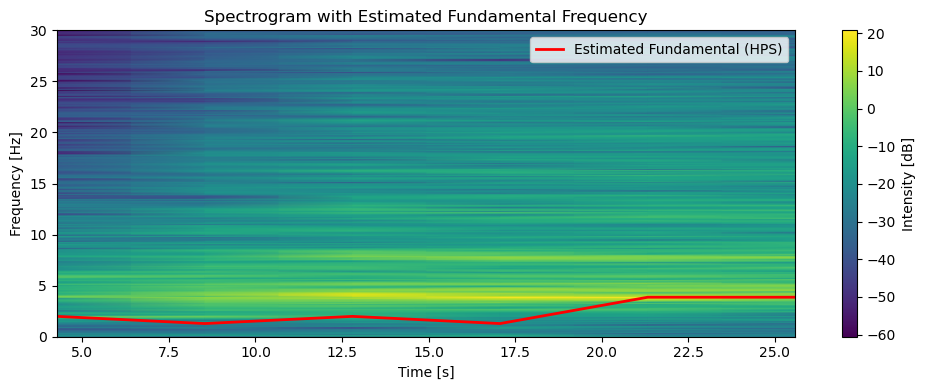

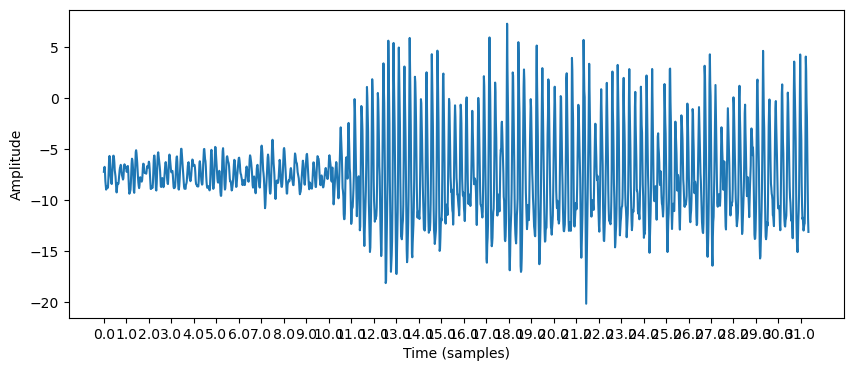

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.fft import fft

def harmonic_product_spectrum(fft_magnitude, max_harmonics=5):
    hps = fft_magnitude.copy()
    for h in range(2, max_harmonics + 1):
        decimated = fft_magnitude[::h]
        hps[:len(decimated)] *= decimated
    return hps

# Assume `signal` is your time-domain input, and `fs` is sampling rate
f, t, Sxx = spectrogram(acc[1], fs=fs, nperseg=512, noverlap=256)

fundamental_freqs = []

for i in range(Sxx.shape[1]):  # iterate over time bins
    spectrum_slice = np.sqrt(Sxx[:, i])  # sqrt converts power to magnitude
    hps = harmonic_product_spectrum(spectrum_slice)
    
    # Optional: limit HPS to a frequency range (e.g., 1–10 Hz)
    freq_mask = (f >= 1) & (f <= 10)
    hps_masked = hps[freq_mask]
    f_masked = f[freq_mask]

    peak_idx = np.argmax(hps_masked)
    fundamental_freqs.append(f_masked[peak_idx])

fundamental_freqs = np.array(fundamental_freqs)

# Plot fundamental frequency over time
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.plot(t, fundamental_freqs, color='red', linewidth=2, label='Estimated Fundamental (HPS)')
plt.title('Spectrogram with Estimated Fundamental Frequency')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Intensity [dB]')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(acc[1])
# convert time to seconds on x axis
plt.xticks(np.arange(0, len(acc[1]), fs), np.arange(0, len(acc[1])/fs, 1))
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_filter_uncertainty_plot(signal, fs, freq=3.0, q=1e-4, r=1e-1):
    """
    Apply Kalman filter tuned to a single frequency and plot uncertainty over time.

    Parameters:
        signal (np.ndarray): 1D input signal
        fs (float): Sampling frequency in Hz
        freq (float): Frequency to track in Hz
        q (float): Process noise covariance
        r (float): Observation noise covariance
    """
    N = len(signal)
    dt = 1 / fs
    omega = 2 * np.pi * freq

    x = np.zeros(2)
    P = np.eye(2)
    Q = q * np.eye(2)
    R = r

    traceP = np.zeros(N)

    for k in range(N):
        H = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
        y = signal[k]

        x_pred = x
        P_pred = P + Q

        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T / S
        x = x_pred + (K.flatten() * (y - H @ x_pred)).flatten()
        P = (np.eye(2) - K @ H) @ P_pred

        traceP[k] = np.trace(P)

    # Plotting uncertainty (trace of covariance) over time
    t = np.arange(N) / fs
    plt.figure(figsize=(10, 4))
    plt.plot(t, traceP, color='tab:blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Trace of Covariance (Uncertainty)')
    plt.title(f'Kalman Filter Uncertainty Over Time (Freq = {freq} Hz)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


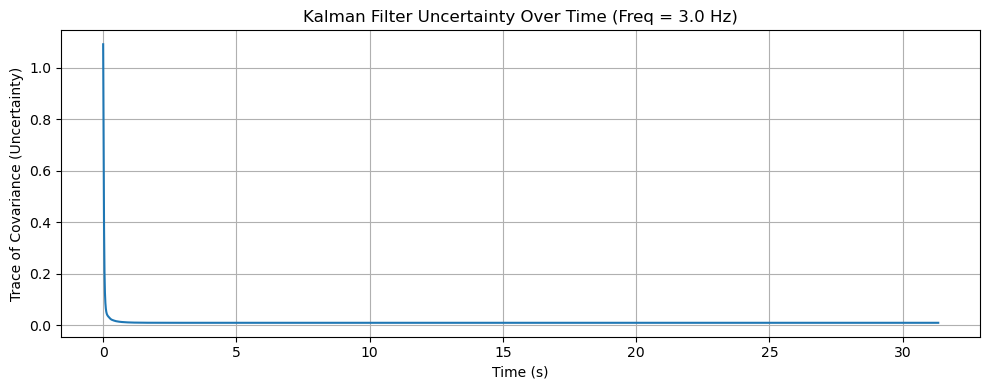

In [ ]:
kalman_filter_uncertainty_plot(acc[0], fs=60, freq=3.0)


In [ ]:
from scipy.signal import detrend

# Use one axis of acceleration or gyro data
signal = acc[1]  # for example, Y-axis acceleration
signal = detrend(signal)  # remove linear trend
signal = signal - signal.mean()  # center the signal


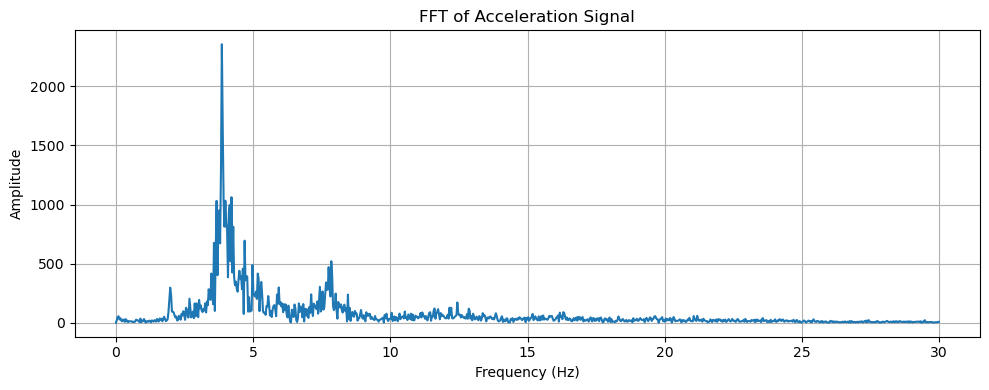

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fs = 60  # sampling rate (Hz) 
n = len(signal)
freqs = np.fft.rfftfreq(n, d=1/fs)
fft_vals = np.abs(np.fft.rfft(signal))

plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_vals)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of Acceleration Signal')
plt.grid(True)
plt.tight_layout()
plt.show()


Harmonic 2.0 Hz: closest peak at 1.98 Hz with amplitude 297.26
Harmonic 4.0 Hz: closest peak at 3.99 Hz with amplitude 1032.73
Harmonic 6.0 Hz: closest peak at 5.93 Hz with amplitude 298.61
Harmonic 8.0 Hz: closest peak at 8.01 Hz with amplitude 247.36
Harmonic 10.0 Hz: closest peak at 8.45 Hz with amplitude 238.76


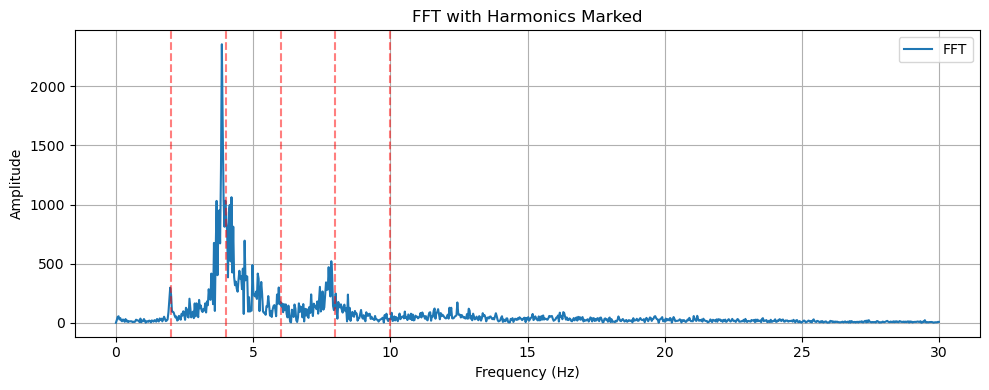

In [ ]:
f0 = 2.0  # fundamental frequency in Hz
import numpy as np
from scipy.signal import find_peaks

# FFT setup
n = len(signal)
fs = 60  # sampling frequency
freqs = np.fft.rfftfreq(n, d=1/fs)
fft_vals = np.abs(np.fft.rfft(signal))

# Find local peaks in the FFT
peaks, _ = find_peaks(fft_vals, height=np.max(fft_vals)*0.1)  # adjustable threshold
peak_freqs = freqs[peaks]
peak_amps = fft_vals[peaks]

# Print harmonic candidates
harmonics = [f0 * i for i in range(1, 6)]  # e.g., 3Hz, 6Hz, 9Hz, ...
for h in harmonics:
    closest_idx = np.argmin(np.abs(peak_freqs - h))
    print(f"Harmonic {h:.1f} Hz: closest peak at {peak_freqs[closest_idx]:.2f} Hz with amplitude {peak_amps[closest_idx]:.2f}")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_vals, label='FFT')
for h in harmonics:
    plt.axvline(h, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT with Harmonics Marked')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
harmonic_ratios = []
fundamental_idx = np.argmin(np.abs(peak_freqs - f0))
for h in harmonics[1:]:  # skip fundamental
    idx = np.argmin(np.abs(peak_freqs - h))
    ratio = peak_amps[idx] / peak_amps[fundamental_idx]
    harmonic_ratios.append((h, ratio))
    print(f"Harmonic {h:.1f} Hz is {ratio:.2f}x the amplitude of the fundamental")


Harmonic 4.0 Hz is 3.47x the amplitude of the fundamental
Harmonic 6.0 Hz is 1.00x the amplitude of the fundamental
Harmonic 8.0 Hz is 0.83x the amplitude of the fundamental
Harmonic 10.0 Hz is 0.80x the amplitude of the fundamental


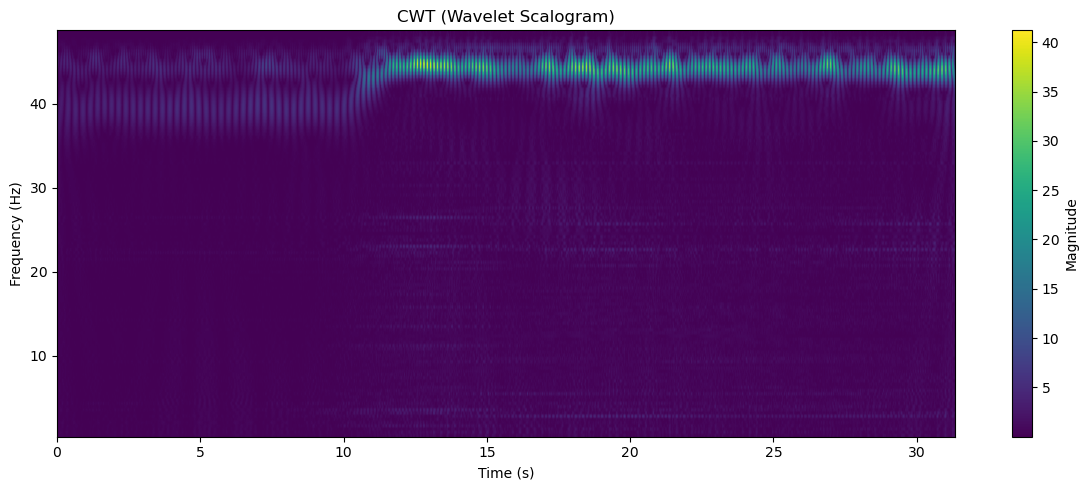

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Sampling settings
fs = 60  # Hz
dt = 1 / fs
n = len(signal)

# Wavelet settings
scales = np.arange(1, 128)
wavelet = 'morl'
fc = pywt.central_frequency(wavelet)  # ≈ 0.8125 for Morlet

# Compute CWT
coeffs, _ = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

# Convert scales to actual frequencies in Hz
freqs = fc / (scales * dt)

# Plot scalogram
plt.figure(figsize=(12, 5))
plt.imshow(np.abs(coeffs), extent=[0, n/fs, freqs[-1], freqs[0]],
           cmap='viridis', aspect='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('CWT (Wavelet Scalogram)')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt, detrend

def preprocess_signal(signal, fs=60.0, hp_cutoff=1.0, order=4):
    """
    High-pass filter and detrend the signal.

    Parameters:
        signal (np.ndarray): 1D or 2D signal (channels x time or time).
        fs (float): Sampling frequency in Hz.
        hp_cutoff (float): High-pass cutoff in Hz.
        order (int): Filter order.

    Returns:
        np.ndarray: Filtered signal.
    """
    def highpass(sig):
        Wn = hp_cutoff / (0.5 * fs)
        if not 0 < Wn < 1:
            raise ValueError(f"Invalid cutoff: {Wn:.3f}. Adjust hp_cutoff or fs.")
        b, a = butter(order, Wn, btype='high')
        return filtfilt(b, a, sig)

    if signal.ndim == 1:
        signal = detrend(signal)
        signal = highpass(signal)
    elif signal.ndim == 2:
        for i in range(signal.shape[0]):
            signal[i] = detrend(signal[i])
            signal[i] = highpass(signal[i])
    else:
        raise ValueError("Signal must be 1D or 2D")

    return signal


In [ ]:
# You can now just run this:
gyro = preprocess_signal(gyro, fs=60)
acc = preprocess_signal(acc, fs=60)


In [ ]:
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

def plot_gyro_fft(gyro_data, fs):
    for i, label in enumerate(['X', 'Y', 'Z']):
        signal = gyro_data[i]
        n = len(signal)
        freqs = rfftfreq(n, 1/fs)
        fft_vals = np.abs(rfft(signal))

        plt.figure(figsize=(8, 3))
        plt.plot(freqs, fft_vals)
        plt.title(f'Gyroscope FFT - {label}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


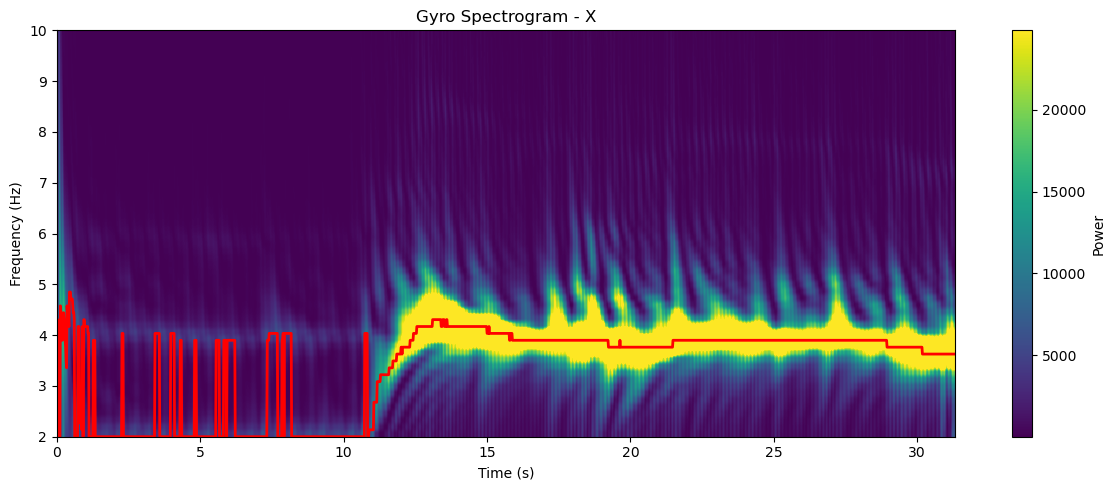

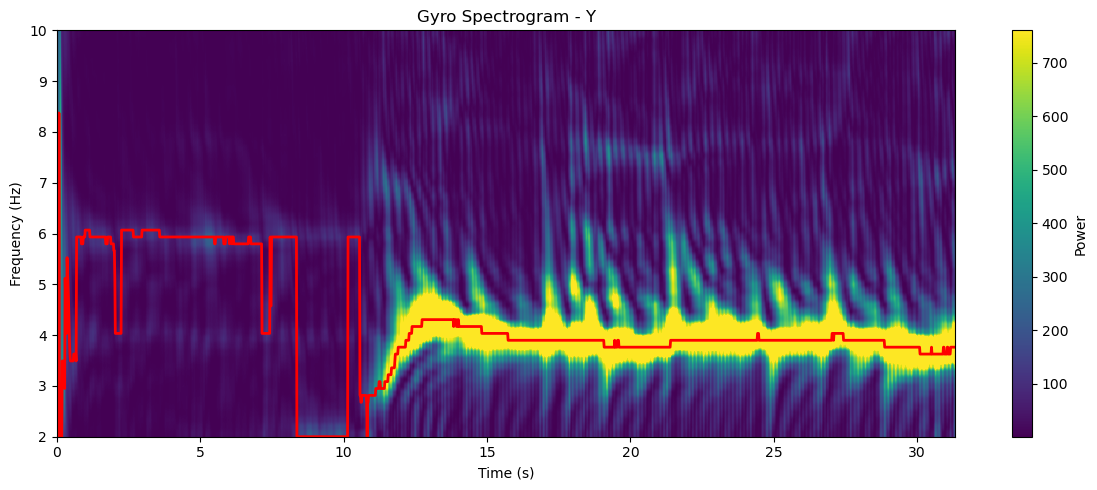

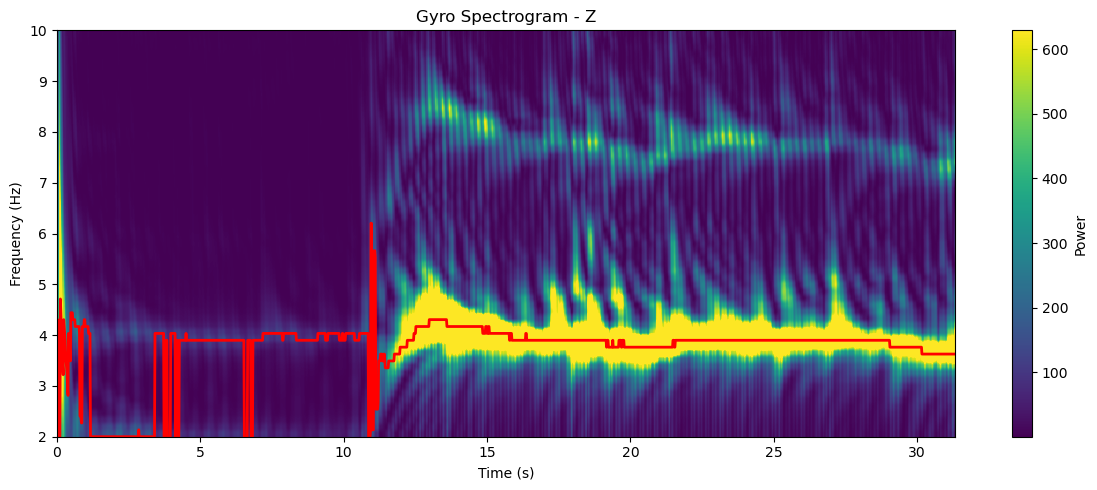

In [ ]:
# Assume you already have: kalman_filter_bank_spectrogram(signal, fs, freqs)

freqs = np.linspace(2, 10, 60)  # e.g., tremor range
for i, label in enumerate(['X', 'Y', 'Z']):
    spec = kalman_filter_bank_spectrogram(gyro[i], fs, freqs)
    plot_kalman_spectrogram(spec, freqs, fs, title=f'Gyro Spectrogram - {label}')


/Users/alinakrause/anaconda3/envs/NDS_project/lib/python3.12/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


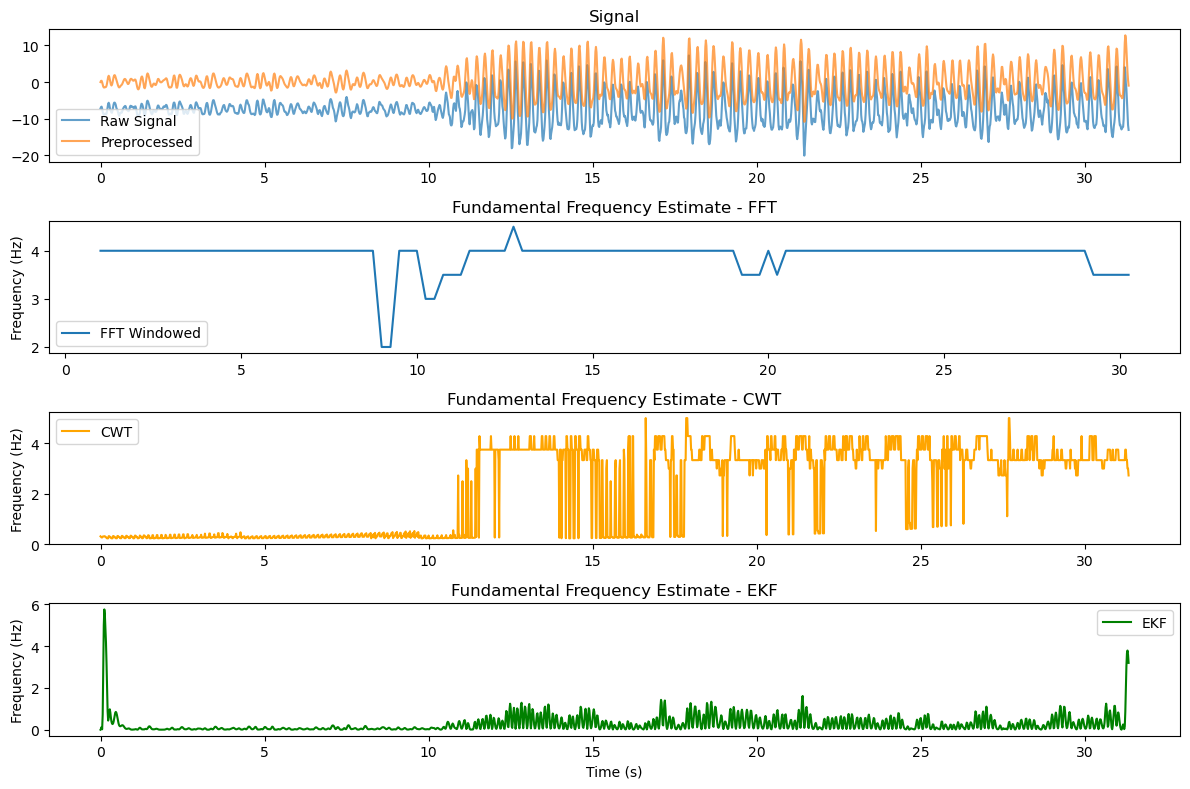

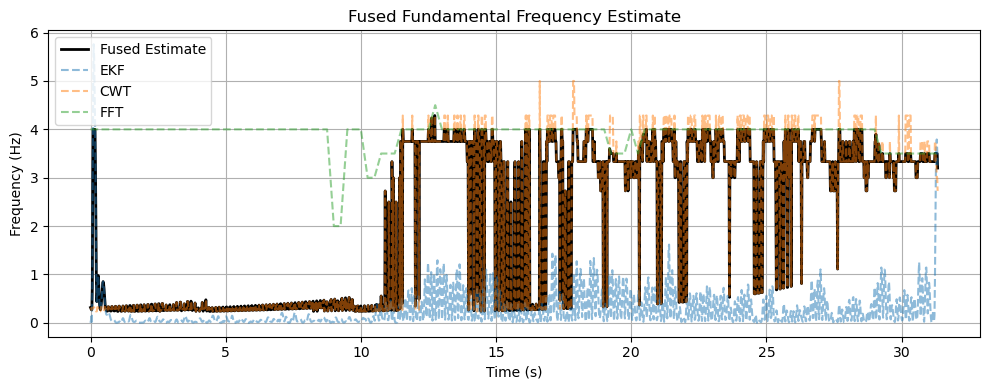

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, stft
from scipy.fft import fft, fftfreq
import pywt

# --- 1. Generate or load a test signal (simulate tremor)
fs = 60  # Sampling rate
t = np.arange(0, 30, 1/fs)  # 30 seconds
signal = acc[1]
t = np.arange(0, len(signal)) / fs  # Adjust time vector to match signal length

# --- 2. Preprocess signal (bandpass)
def bandpass_filter(data, fs, lowcut=1.0, highcut=10.0):
    b, a = butter(3, [lowcut / (fs/2), highcut / (fs/2)], btype='band')
    return filtfilt(b, a, data)

preprocessed = bandpass_filter(signal, fs)

# --- 3. FFT-based short-time frequency estimate
win_size = int(2 * fs)
step = int(0.25 * fs)
freqs_fft = []
times_fft = []

for i in range(0, len(preprocessed) - win_size, step):
    segment = preprocessed[i:i+win_size]
    fft_vals = np.abs(fft(segment))
    freqs = fftfreq(win_size, 1/fs)
    mask = (freqs >= 1) & (freqs <= 10)
    fft_vals = fft_vals[mask]
    freqs_masked = freqs[mask]
    fundamental = freqs_masked[np.argmax(fft_vals)]
    freqs_fft.append(fundamental)
    times_fft.append(t[i + win_size//2])

freqs_fft = np.array(freqs_fft)
times_fft = np.array(times_fft)

# --- 4. CWT-based frequency tracking
scales = np.arange(1, 128)
coef, freqs_cwt = pywt.cwt(preprocessed, scales, 'cmor', sampling_period=1/fs)
power = np.abs(coef)**2
freq_cwt = freqs_cwt[np.argmax(power, axis=0)]

# --- 5. EKF for frequency tracking

freqs = np.linspace(1, 10, 100) 
freq_ekf = kalman_filter_bank_spectrogram(preprocessed, fs,freqs)[0]

# --- 6. Plot all estimates
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(t, signal, label='Raw Signal', alpha=0.7)
plt.plot(t, preprocessed, label='Preprocessed', alpha=0.7)
plt.title("Signal")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(times_fft, freqs_fft, label='FFT Windowed')
plt.title("Fundamental Frequency Estimate - FFT")
plt.ylabel("Frequency (Hz)")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t, freq_cwt, label='CWT', color='orange')
plt.title("Fundamental Frequency Estimate - CWT")
plt.ylabel("Frequency (Hz)")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(t, freq_ekf, label='EKF', color='green')
plt.title("Fundamental Frequency Estimate - EKF")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.legend()

plt.tight_layout()
plt.show()

# --- 7. Fusion (median)
from scipy.interpolate import interp1d

# Interpolate FFT to match EKF timebase
fft_interp = interp1d(times_fft, freqs_fft, bounds_error=False, fill_value="extrapolate")
fit_interp = fft_interp(t)
fused = np.median(np.vstack([fit_interp, freq_cwt, freq_ekf]), axis=0)

# Plot fused estimate
plt.figure(figsize=(10, 4))
plt.plot(t, fused, label='Fused Estimate', color='black', linewidth=2)
plt.plot(t, freq_ekf, '--', alpha=0.5, label='EKF')
plt.plot(t, freq_cwt, '--', alpha=0.5, label='CWT')
plt.plot(t, fit_interp, '--', alpha=0.5, label='FFT')
plt.title("Fused Fundamental Frequency Estimate")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
